<a href="https://www.kaggle.com/code/taimour/blend-xgb-lgbm-cat-eda-cmi-internet-usage?scriptVersionId=207607581" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align:center"><span style="background-color:#a8edc4;color:black;padding:10px;border-radius:40px;">💻 Blend XGB, LGBM, CAT - EDA 📊</span></div>


![](https://i.postimg.cc/HL1fFP5X/pexels-ron-lach-9783375.jpg)

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🎒Import Libraries</span>



In [1]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.base import clone
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
# pd.options.display.max_columns = None

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

n_splits = 5

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑Explaining Python Libraries</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Essential Libraries</h2>
  <ul>
    <li><strong>NumPy:</strong> Foundation for numerical computations</li>
    <li><strong>Pandas:</strong> Data structures and analysis tools</li>
    <li><strong>Polars:</strong> High-performance data processing library</li>
    <li><strong>Scikit-learn:</strong> Machine learning algorithms and tools</li>
    <li><strong>SciPy:</strong> Scientific computing library</li>
  </ul>
  <h2 style="color:black;">Operating System and Visualization Tools</h2>
  <ul>
    <li><strong>OS:</strong> Interacts with the operating system</li>
    <li><strong>Matplotlib:</strong> Plotting library for creating visualizations</li>
    <li><strong>Seaborn:</strong> High-level interface for drawing statistical graphics</li>
    <li><strong>Matplotlib.ticker:</strong> Customizes tick labels and formatting</li>
  </ul>
  <h2 style="color:black;">Text Processing and Output Formatting</h2>
  <ul>
    <li><strong>RE:</strong> Regular expression operations</li>
    <li><strong>Colorama:</strong> Colored text output in the terminal</li>
    <li><strong>TQDM:</strong> Progress bar for long-running operations</li>
    <li><strong>IPython.display:</strong> Displays output in Jupyter notebooks</li>
    <li><strong>Concurrent.futures:</strong> Parallel execution of tasks</li>
    <li><strong>Warnings:</strong> Manages warning messages</li>
  </ul>
  <h2 style="color:black;">Machine Learning Models and Tools</h2>
  <ul>
    <li><strong>Scikit-learn.model_selection:</strong> Data splitting and model evaluation</li>
    <li><strong>Scikit-learn.metrics:</strong> Calculation of performance metrics</li>
    <li><strong>Scikit-learn.pipeline:</strong> Chaining multiple data processing steps</li>
    <li><strong>Scikit-learn.preprocessing:</strong> Data normalization and scaling</li>
    <li><strong>mlxtend.regressor.StackingCVRegressor:</strong> Stacking ensemble method</li>
    <li><strong>LightGBM:</strong> Gradient boosting machine</li>
    <li><strong>CatBoost:</strong> Gradient boosting machine</li>
    <li><strong>XGBoost:</strong> Gradient boosting machine</li>
  </ul>
  <h2 style="color:black;">Additional Modules and Settings</h2>
  <ul>
    <li><strong>Datetime:</strong> Works with dates and times</li>
    <li><strong>Scikit-learn.model_selection.KFold:</strong> k-fold cross-validation</li>
    <li><strong>Scikit-learn.preprocessing.LabelEncoder:</strong> Encodes categorical variables</li>
    <li><strong>Hyperparameter:</strong> `n_splits = 5`</li>
    <li><strong>Configuration:</strong> `warnings.filterwarnings('ignore')` and `pd.options.display.max_columns = None`</li>
  </ul>
</div>

# <span style="background-color:#79a5ed;padding:10px;border-radius:40px;">✨Preprocessing</span>

In [2]:
# def process_file(filename, dirname):
#     df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
#     df.drop('step', axis=1, inplace=True)
#     return df.describe().values.reshape(-1), filename.split('=')[1]

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    
    # Calculate the mean for each column
    means = df.mean().values
    
    return means, filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

100%|██████████| 2/2 [00:00<00:00, 27.89it/s]


Train Shape : (2736, 71) || Test Shape : (20, 70)


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑Explaining Preprocessing</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Time Series Loading Function (<strong>load_time_series</strong>)</h2>
  <ul>
    <li>Takes a directory path containing time series data in Parquet format as input.</li>
    <li>Uses <strong>os.listdir</strong> to get a list of file names in the directory.</li>
    <li>Utilizes a <strong>ThreadPoolExecutor</strong> to parallelize the processing of each file.</li>
    <li>The <strong>process_file</strong> function is called for each file.</li>
    <li><strong>process_file</strong> reads the Parquet file using <strong>pd.read_parquet</strong>.</li>
    <li>It drops the "step" column (assuming it's not relevant).</li>
    <li>It calculates descriptive statistics for the remaining columns using <strong>df.describe().values.reshape(-1)</strong>.</li>
    <li>The function returns a tuple containing the statistics and the file name (split to extract the ID).</li>
    <li>Finally, the function combines the statistics from all files into a DataFrame and sets the "id" column based on the file names.</li>
  </ul>

  <h2 style="color:black;">Data Loading and Merging</h2>
  <ul>
    <li>Three datasets are loaded: <strong>train.csv</strong>, <strong>test.csv</strong>, and <strong>sample_submission.csv</strong>.</li>
    <li>The <strong>load_time_series</strong> function is used to load time series data for both training and testing sets.</li>
    <li>The time series dataframes are merged with the main datasets based on the "id" column.</li>
    <li>The "id" column is dropped from the main datasets after merging.</li>
  </ul>

  <h2 style="color:black;">Feature Selection and Pre-processing</h2>
  <ul>
    <li>A list of pre-defined features (<strong>featuresCols</strong>) is created.</li>
    <li>This list combines features from the main datasets and the time series statistics.</li>
    <li>Both training and testing sets are filtered to include only these features.</li>
    <li>Missing values in the "sii" column (presumably the target variable) are dropped from the training set.</li>
  </ul>

  <h2 style="color:black;">Categorical Feature Handling</h2>
  <ul>
    <li>A list of categorical features (<strong>cat_c</strong>) is defined.</li>
    <li>A function <strong>update</strong> is defined to fill missing values in these features with "Missing" and convert them to categorical data type.</li>
    <li>Both training and testing sets are updated using this function.</li>
  </ul>

  <h2 style="color:black;">Feature Encoding</h2>
  <ul>
    <li>A function <strong>create_mapping</strong> creates a dictionary mapping unique values in a categorical column to integer values.</li>
    <li>Separate mappings are created for training and testing sets to avoid data leakage (using the training set information to predict the test set).</li>
    <li>The categorical features are replaced with their corresponding integer values based on the mappings.</li>
    <li>This step encodes the categorical information numerically for the machine learning model.</li>
  </ul>

  <h2 style="color:black;">Printing Final Shapes</h2>
  <ul>
    <li>The function prints the final shapes of the training and testing sets after all processing.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🔎View Data</span>

In [3]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,...,-0.167890,0.047388,-10.580416,0.000000,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683
5,3,13,1,0,50.0,1,22.279952,59.5,112.2,NaN,...,-0.631731,0.011926,-55.630768,0.655708,16.771982,3838.189453,4.321212e+13,3.909848,3.0,79.435593


In [4]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,...,-0.16789,0.047388,-10.580416,0.0,42.29631,4053.579102,5.046215e+13,4.470182,3.0,53.201683
4,3,18,1,3,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.021536,0.022214,-1.02237,0.022853,-88.280762,0.0,53.0,4188.0,56940000000000,4,3,41.0
1,0.022005,0.022187,-1.01974,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,0.02224,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.5,4188.5,56955000000000,4,3,41.0
4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.0,57235000000000,4,3,41.0
…,…,…,…,…,…,…,…,…,…,…,…,…
43325,-0.008333,-0.02362,-1.006901,0.007224,-88.595741,0.0,0.0,3824.0,57580000000000,6,3,85.0
43326,0.04873,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.0,3824.0,57640000000000,6,3,85.0
43327,0.38737,0.793151,-0.402214,0.069961,-24.097908,0.0,0.0,3824.0,57645000000000,6,3,85.0


# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">📊 Exploratory Data Analysis</span>

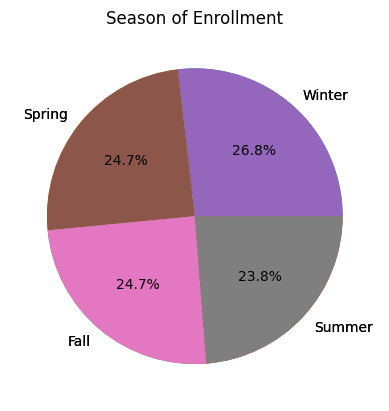

In [6]:
vc = train['Basic_Demos-Enroll_Season'].value_counts()

# Map labels to seasons
season_map = {0: 'Spring', 1: 'Summer', 2: 'Fall', 3: 'Winter'}

# Create labels using the map
labels = [season_map[label] for label in vc.index]

# Plot the pie chart with the updated labels
plt.pie(vc, labels=labels)
# Plot the pie chart
plt.pie(vc.values, labels=labels, autopct="%1.1f%%")  # Add percentages to pie slices
plt.title('Season of Enrollment')
plt.show()

It seems we have almost similar enrollment in all seasons

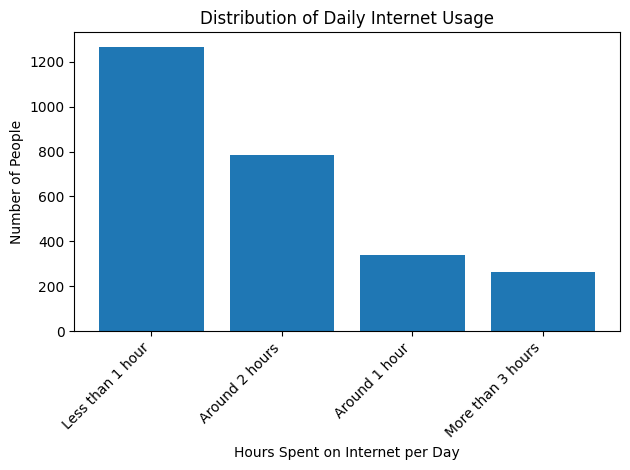

In [7]:
# Assuming you have your DataFrame 'train' with the column 'PreInt_EduHx-computerinternet_hoursday'

vc = train['PreInt_EduHx-computerinternet_hoursday'].value_counts()  # Count occurrences of each value

# Improved InternetHours_map with clearer categories
InternetHours_map = {
    0: 'Less than 1 hour',
    1: 'Around 1 hour',
    2: 'Around 2 hours',
    3: 'More than 3 hours'
}

# Create labels using the map
labels = [InternetHours_map[label] for label in vc.index]

# Create a bar chart
plt.bar(labels, vc.values)  # Use labels for bar positions

# Customize the bar chart for better visualization
plt.xlabel('Hours Spent on Internet per Day')
plt.ylabel('Number of People')
plt.title('Distribution of Daily Internet Usage')
plt.xticks(rotation=45, ha='right')  # Rotate category labels for readability
plt.tight_layout()  # Adjust spacing to prevent overlapping elements

plt.show()

In our dataset majority of people use internet for less than 1 hour. It can be seen that people using internet for more than 3 hours are very less. 

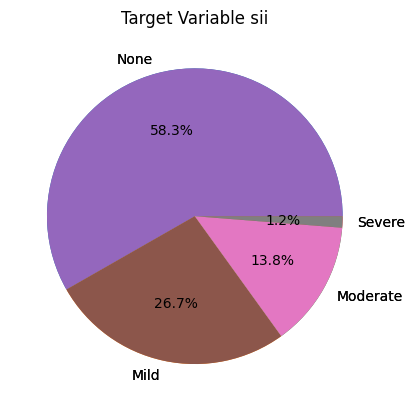

In [8]:
vc = train['sii'].value_counts()

# Map labels to sii
sii_map = {0: 'None', 1: 'Mild', 2: 'Moderate', 3: 'Severe'}

# Create labels using the map
labels = [sii_map[label] for label in vc.index]

# Plot the pie chart with the updated labels
plt.pie(vc, labels=labels)
# Plot the pie chart
plt.pie(vc.values, labels=labels, autopct="%1.1f%%")  # Add percentages to pie slices
plt.title('Target Variable sii')
plt.show()

Pie chart makes it clear that majority of people i.e 58.3% don't have any problem. While 26.7% have only mild problems. So, we can say that 85% of people in our data either have no or mild problem. While in the remaning 15% we see that 13.8% have moderate problem and only 1.2% people show severe problem. As a result in our dataset the number of people who actually have severe problem are only 1.2%, which is a very small percentage as compared to other 3 groups of people.

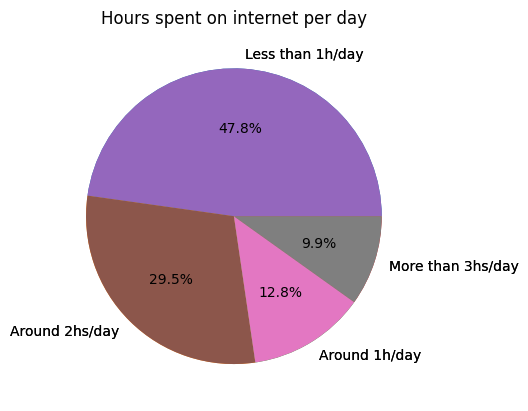

In [9]:
vc = train['PreInt_EduHx-computerinternet_hoursday'].value_counts()

# Map labels for Internet Hours
InternetHours_map = {0: 'Less than 1h/day', 1: 'Around 1h/day', 2: 'Around 2hs/day', 3: 'More than 3hs/day'}

# Create labels using the map
labels = [InternetHours_map[label] for label in vc.index]

# Plot the pie chart with the updated labels
plt.pie(vc, labels=labels)
# Plot the pie chart
plt.pie(vc.values, labels=labels, autopct="%1.1f%%")  # Add percentages to pie slices
plt.title('Hours spent on internet per day')
plt.show()

Viewing the pie chart above it is clear that the people who use internet excessively are only 9.9%. While all other users either use the internet for around 2 hours or less than it.

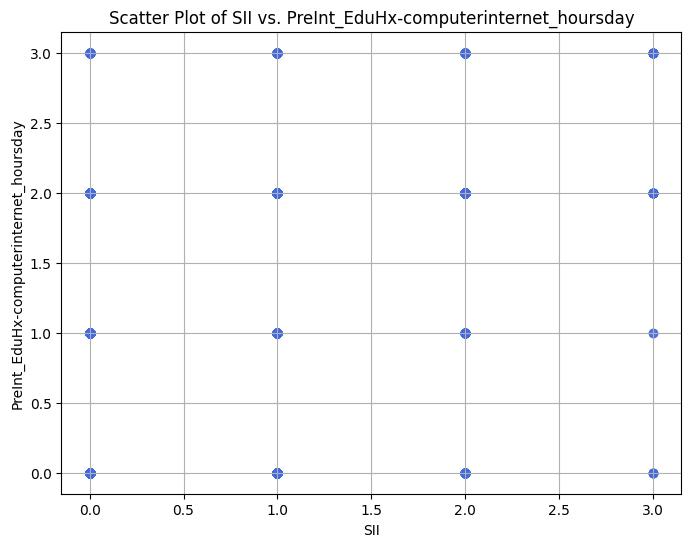

In [10]:
# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size for better visualization
plt.scatter(train['sii'], train['PreInt_EduHx-computerinternet_hoursday'], color='royalblue', alpha=0.7)  # Adjust color and transparency

# Add labels and title
plt.xlabel('SII')
plt.ylabel('PreInt_EduHx-computerinternet_hoursday')
plt.title('Scatter Plot of SII vs. PreInt_EduHx-computerinternet_hoursday')

# Add grid lines for better readability
plt.grid(True)

# Show the plot
plt.show()

Here we have a scatter plot for our target variable i.e SII and number of hours for which internet was used. This plot is interesting but also strange. It shows that we have all possible SII values for all possible internet usage hours per day. This makes it difficult to distinguish and understand that how the SII value changes with time of internet usage change.

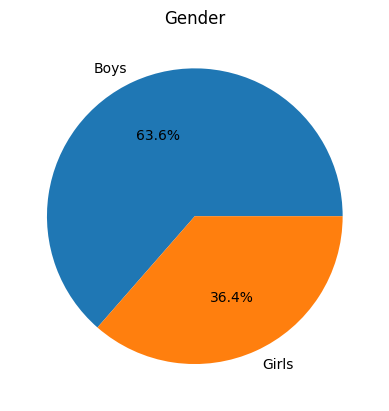

In [11]:
# Get value counts for gender
vc = train['Basic_Demos-Sex'].value_counts()

# Extract counts (assuming 'count' column doesn't exist)
counts = vc.values

# Create labels (assuming 'count' column doesn't exist)
labels = ['Boys', 'Girls']  # Assuming 'Male' maps to 'Boys' and 'Female' to 'Girls'

# Plot the pie chart
plt.pie(counts, labels=labels, autopct="%1.1f%%")  # Add percentages to pie slices
plt.title('Gender')
plt.show()


Majority of people are male in this dataset while we do have girls in a good number too.

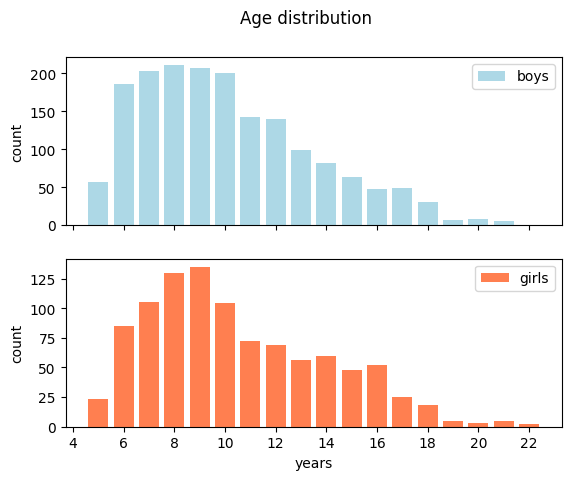

In [12]:
#'train' is DataFrame
_, axs = plt.subplots(2, 1, sharex=True)

for sex in range(2):
  ax = axs.ravel()[sex]

  # Filter by sex using boolean indexing
  sex_filter = train['Basic_Demos-Sex'] == sex
  vc = train[sex_filter]['Basic_Demos-Age'].value_counts()  # Access column after filtering

  # Plot the bar chart
  ax.bar(vc.index, vc.values, color=['lightblue', 'coral'][sex], label=['boys', 'girls'][sex])
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.set_ylabel('count')
  ax.legend()

plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

Majority of people in our dataset are young children or teenagers. We don't have any elder person. Remember we are being asked to determine SII for people in future.

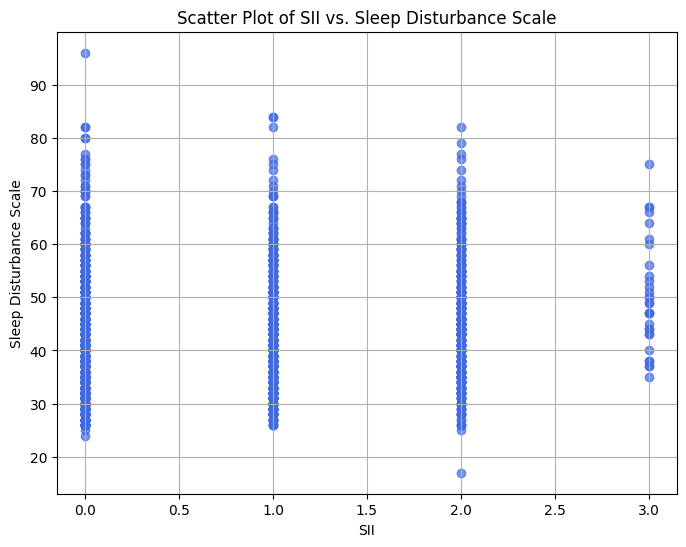

In [13]:
# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size for better visualization
plt.scatter(train['sii'], train['SDS-SDS_Total_Raw'], color='royalblue', alpha=0.7)  # Adjust color and transparency

# Add labels and title
plt.xlabel('SII')
plt.ylabel('Sleep Disturbance Scale')
plt.title('Scatter Plot of SII vs. Sleep Disturbance Scale')

# Add grid lines for better readability
plt.grid(True)

# Show the plot
plt.show()

Scatter plot above shows that the Sleep disturbance scale of different people with SII 0, 1 and 2 is almost in similar range except a few outliers. 
While for SII 3 we have already seen above that we have very less entries so, this can explain why we have less mark/dots for it on the scatter plot. Even if we have less marks/dots for SII 3 they are still inside the same range in which we have the sleep diturbance values for SII 0, 1 and 2. Although the range of SII 3 is smaller as compared to SII 0, 1 and 2 but still I used the words same range because they don't have a big number of spots outside the range of SII 0, 1 and 2.
A surprising point here is this that in case of SII 3 we don't have very high and very low sleep disturbance values. Ideally we would expect that SII 3 should have higher values for sleep disturbance but it is not the case here.

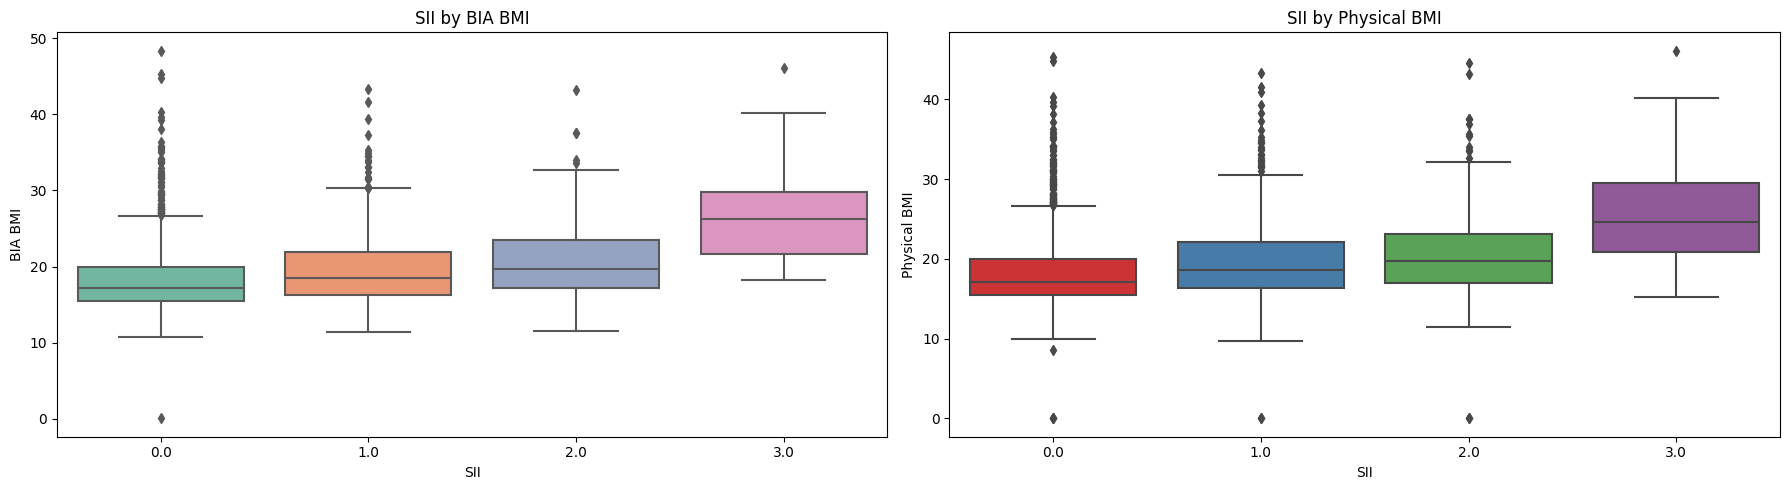

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# SII by BIA_BMI
sns.boxplot(y=train['BIA-BIA_BMI'], x=train['sii'], ax=axes[0], palette="Set2")
axes[0].set_title('SII by BIA BMI')
axes[0].set_ylabel('BIA BMI')
axes[0].set_xlabel('SII')

# SII by Physical-BMI
sns.boxplot(y=train['Physical-BMI'], x=train['sii'], ax=axes[1], palette="Set1")
axes[1].set_title('SII by Physical BMI')
axes[1].set_ylabel('Physical BMI')
axes[1].set_xlabel('SII')

plt.tight_layout()
plt.show()

Recorded values for BIA BMI and Physical BMI seem slightly different. 

**There are two possible reasons for this:**
1. There is some discrepancy or mistake in measurement of BMI.
2. Both BMI's might have been calculated at different ages for same person.

In [15]:
DROP_COLS = [
    "Basic_Demos-Enroll_Season", "CGAS-Season", "Physical-Season",
    "Fitness_Endurance-Season", "FGC-Season", "BIA-Season",
    "PAQ_A-Season", "PAQ_C-Season", "SDS-Season", "PreInt_EduHx-Season"
]

train = train.drop(DROP_COLS,axis=1)
test = test.drop(DROP_COLS,axis=1)

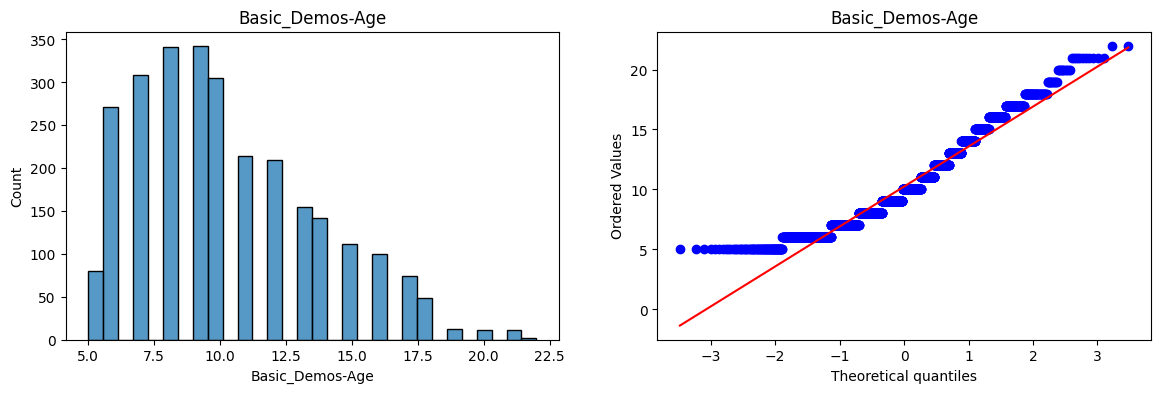

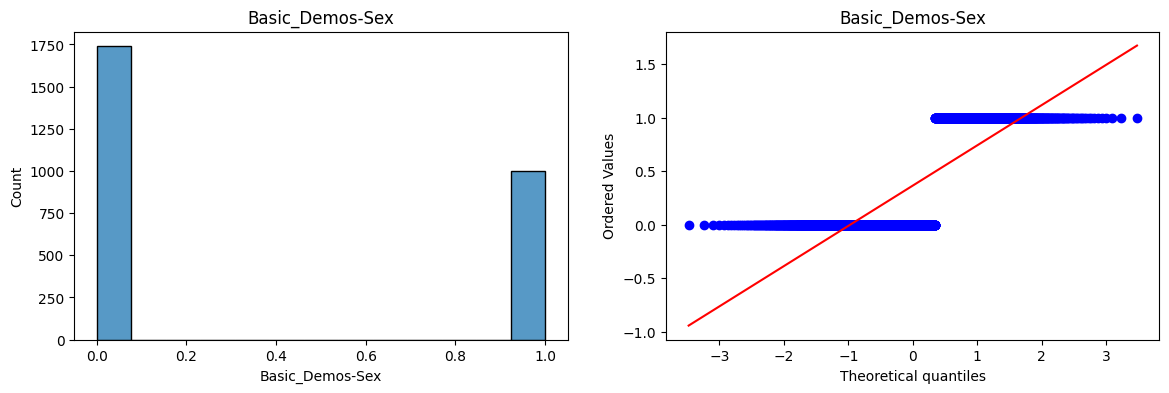

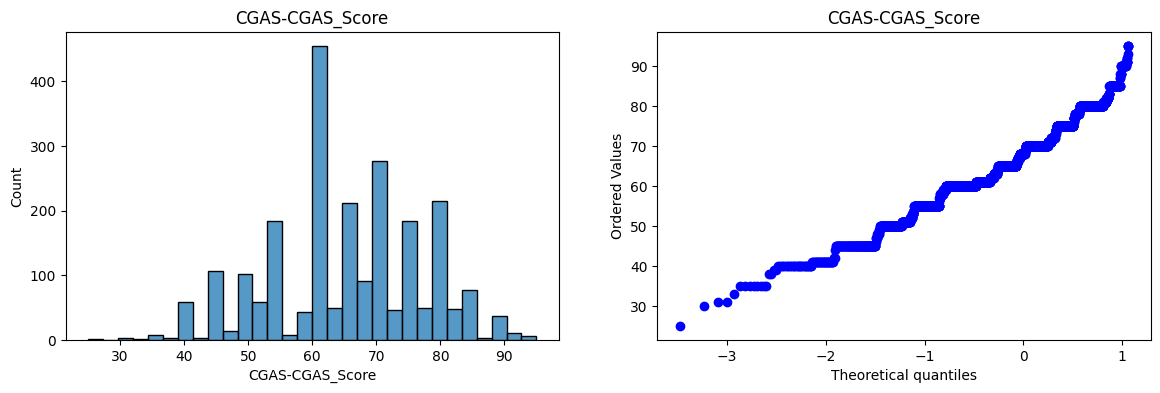

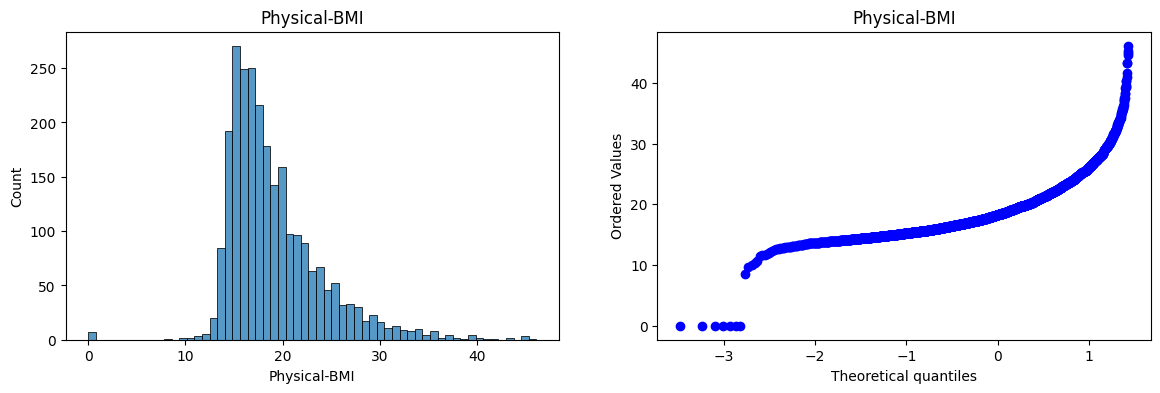

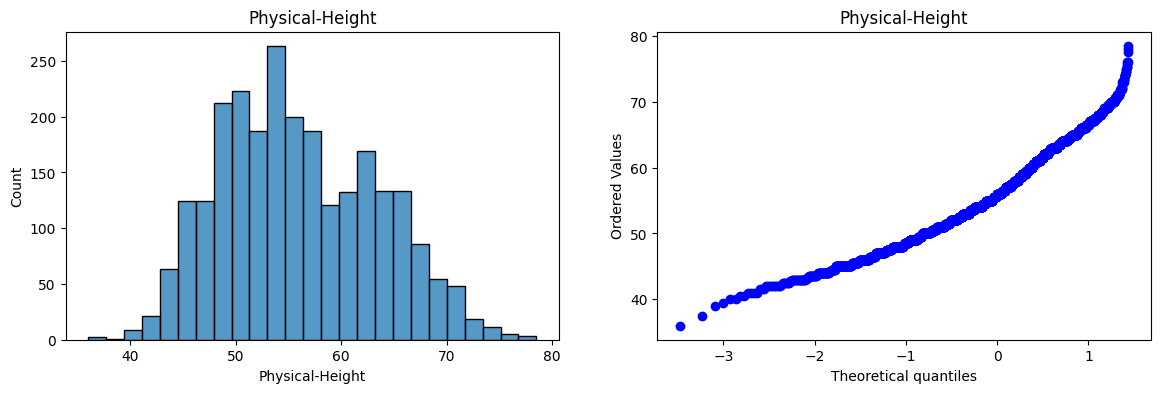

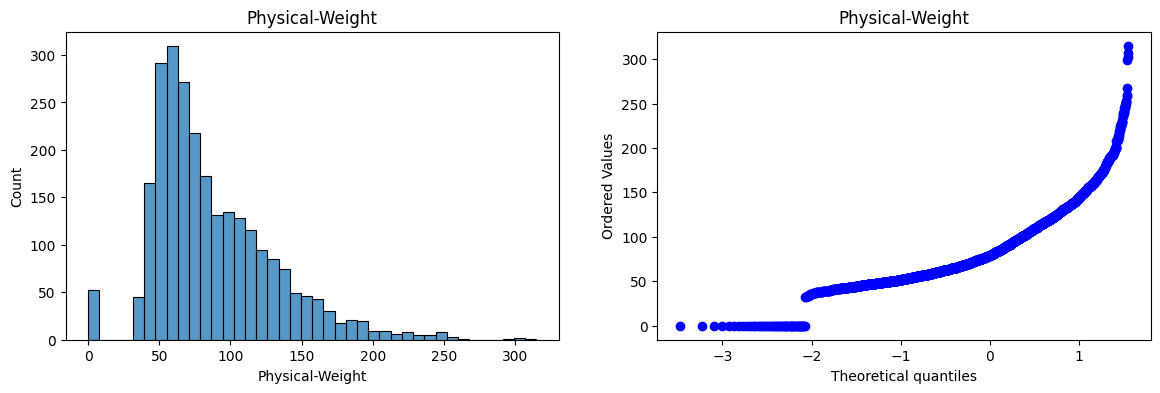

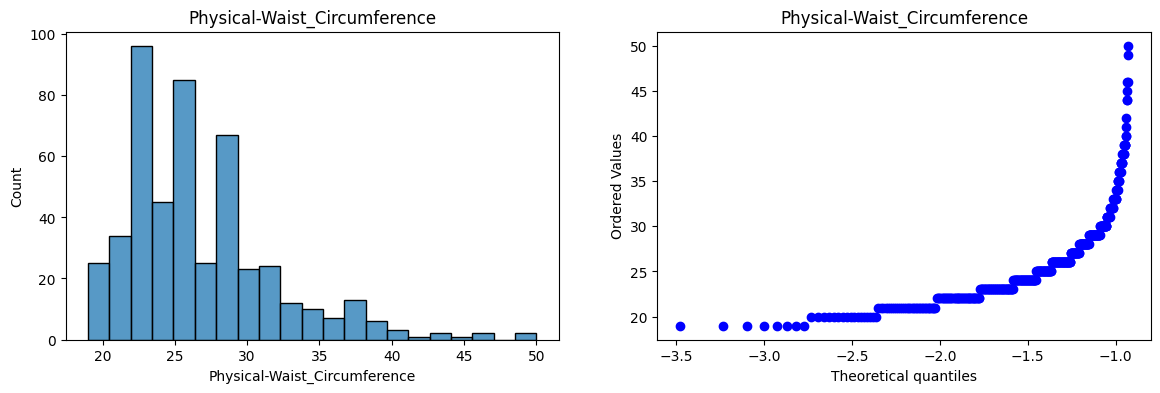

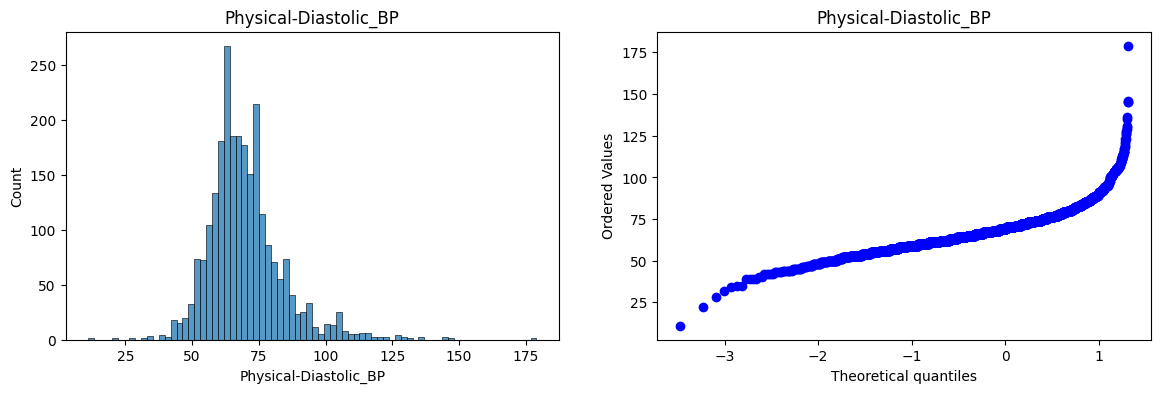

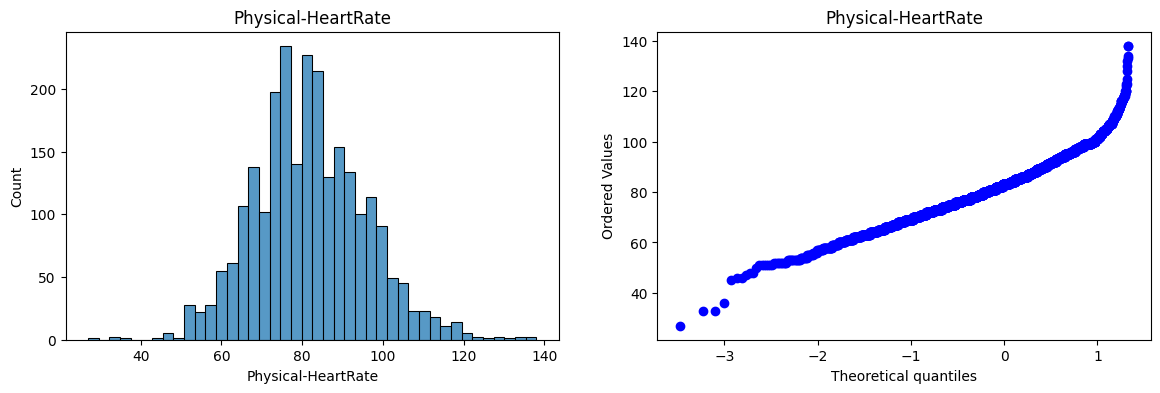

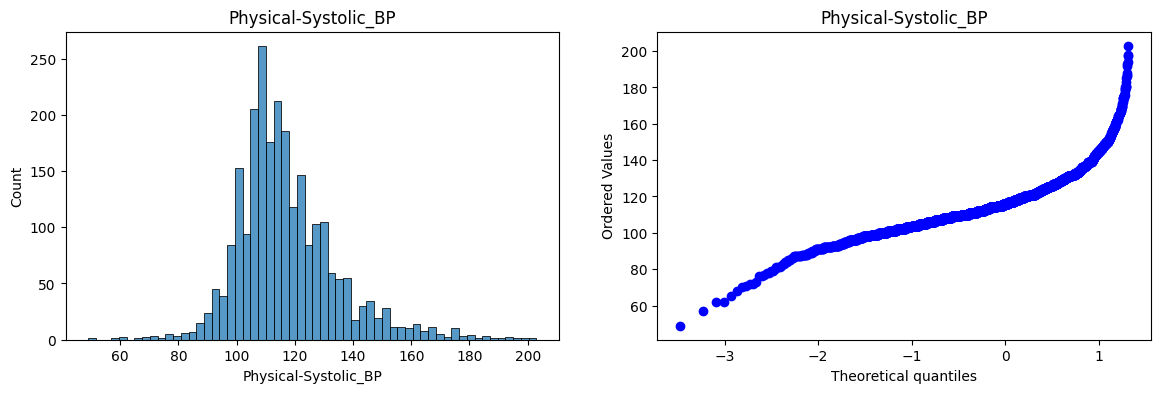

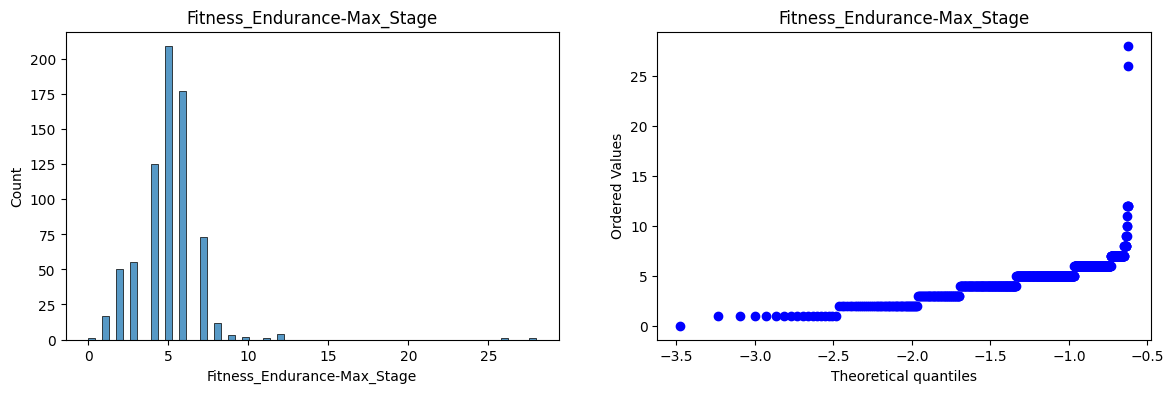

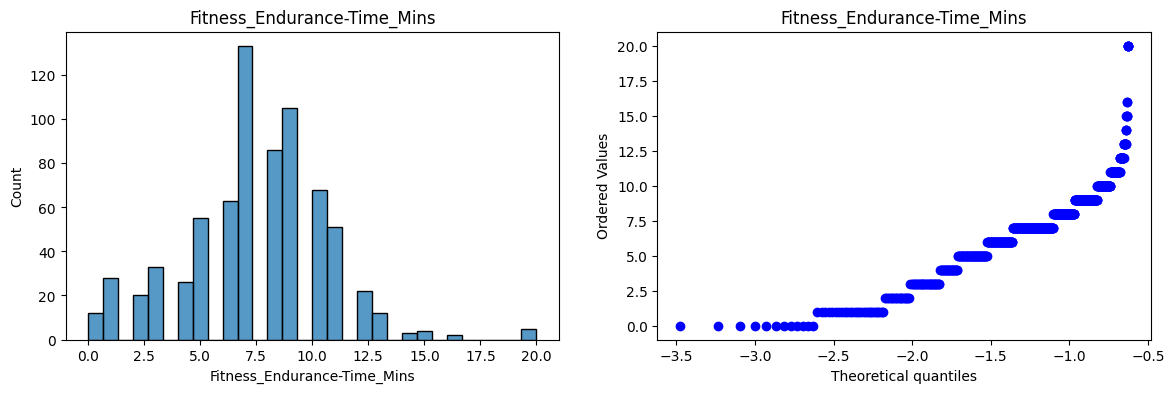

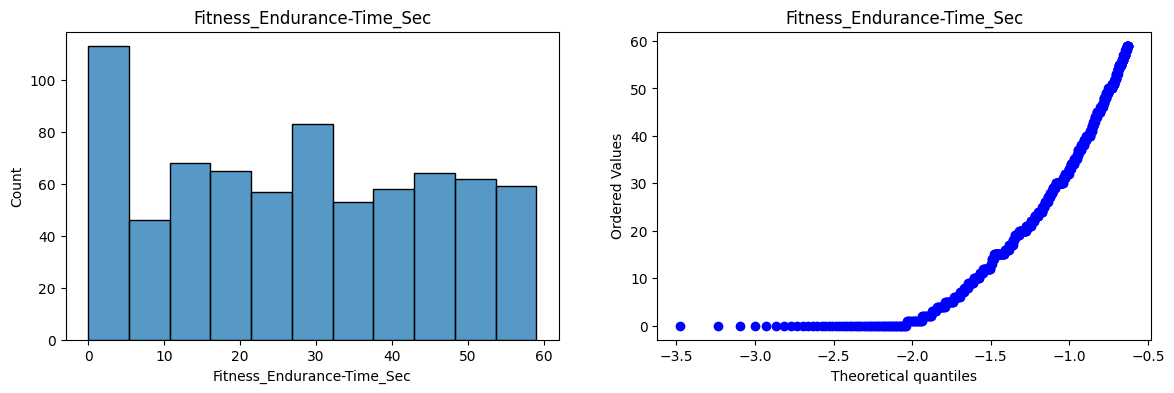

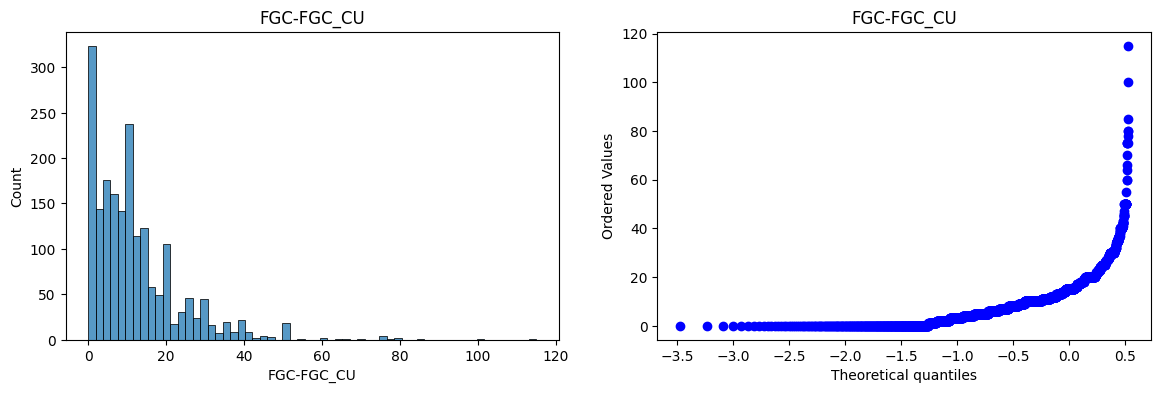

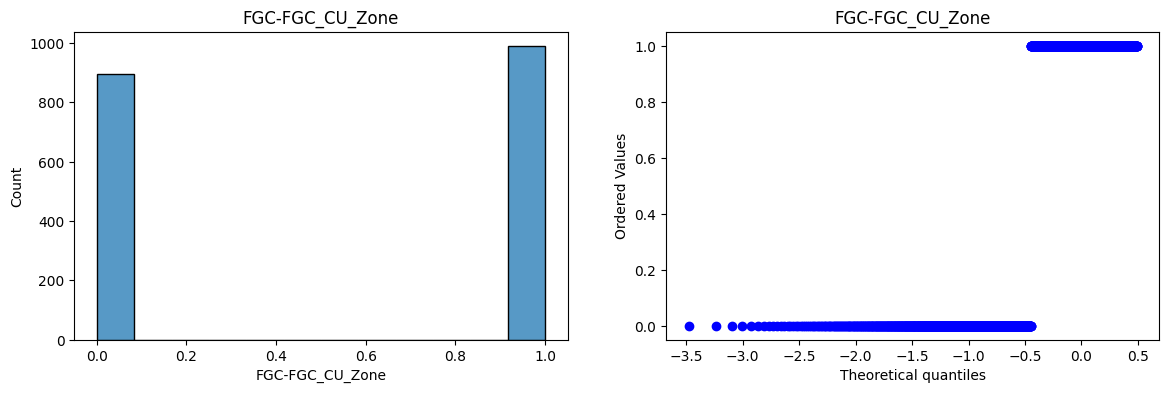

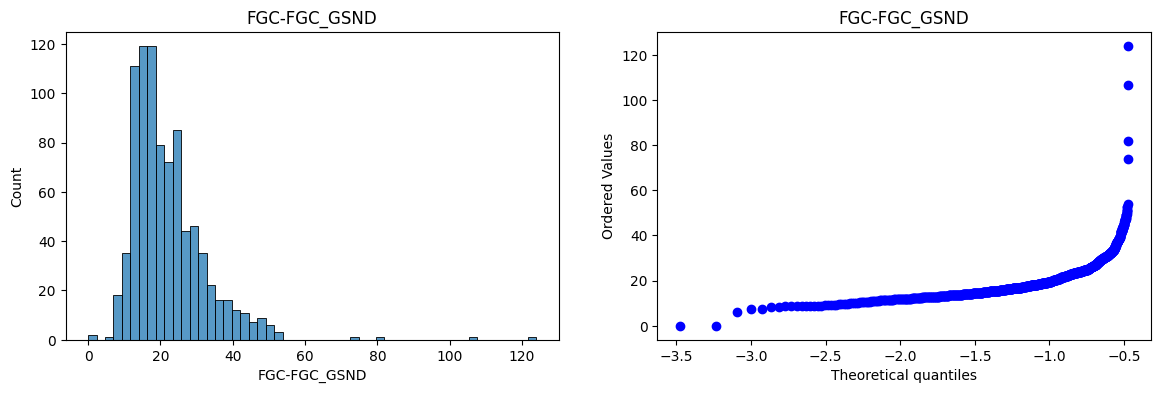

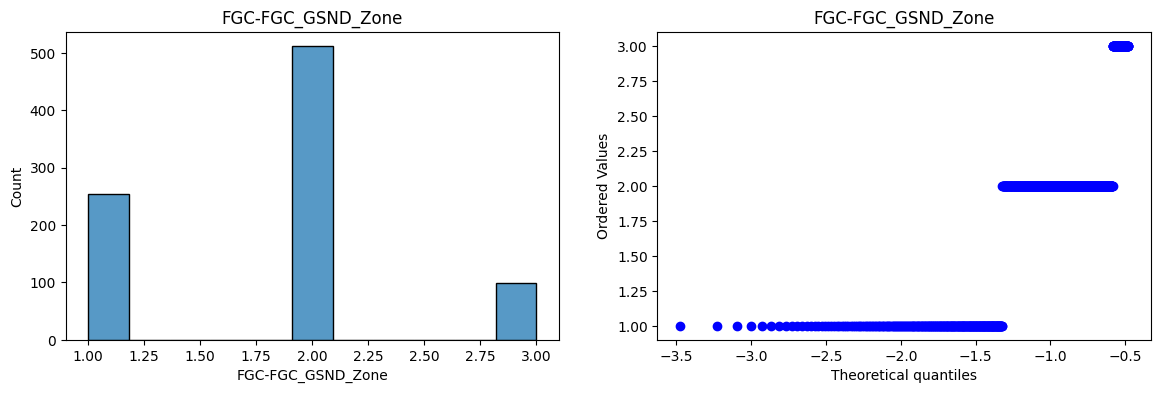

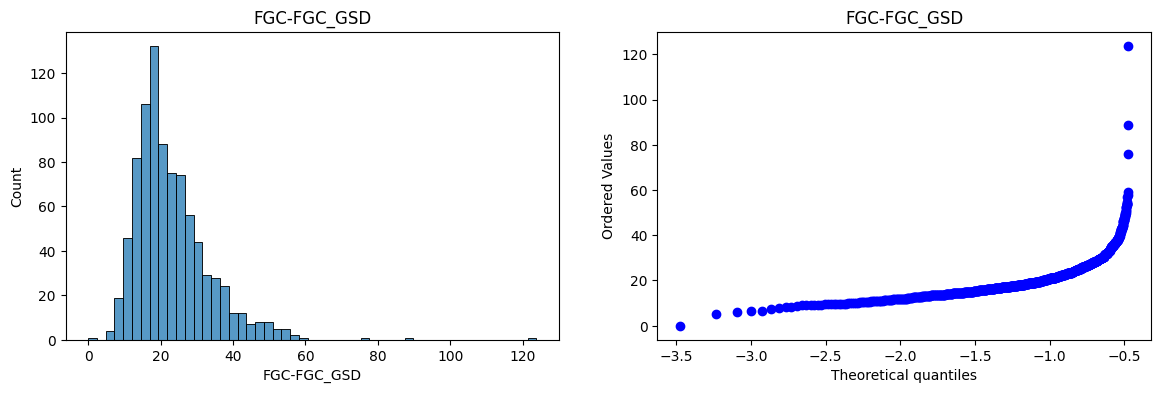

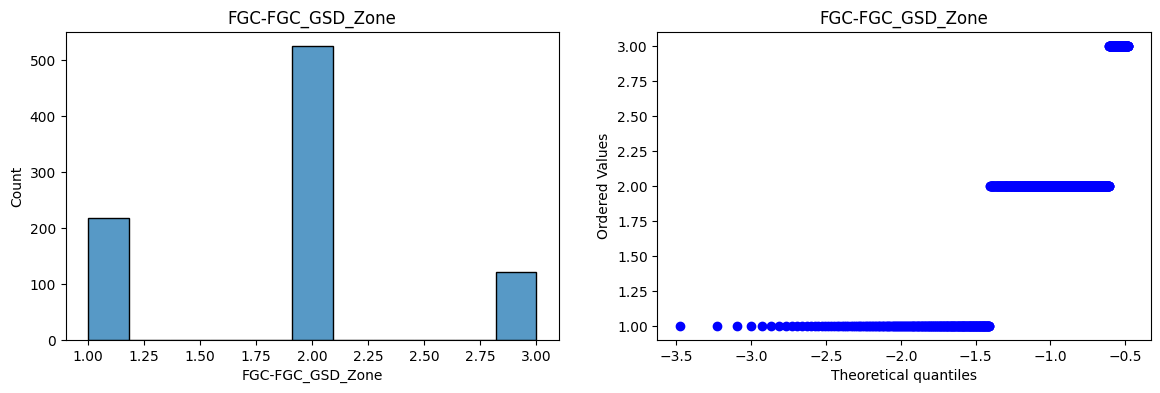

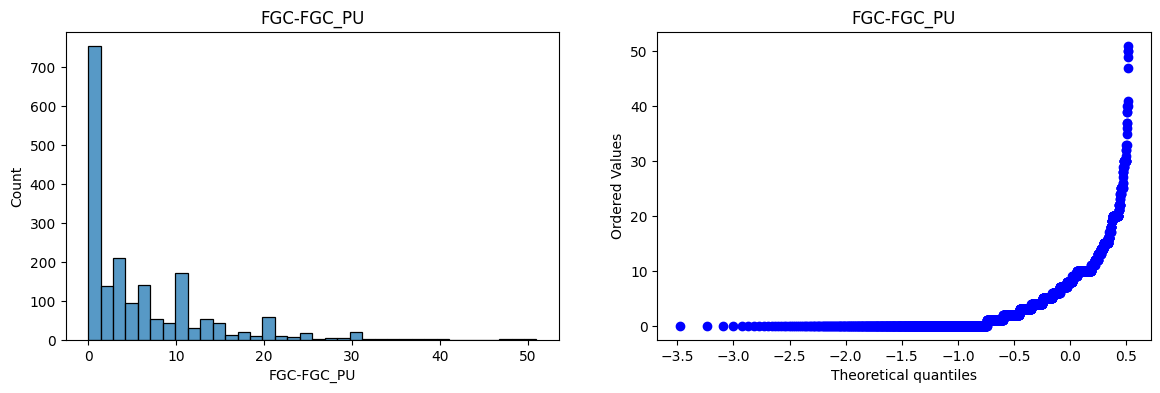

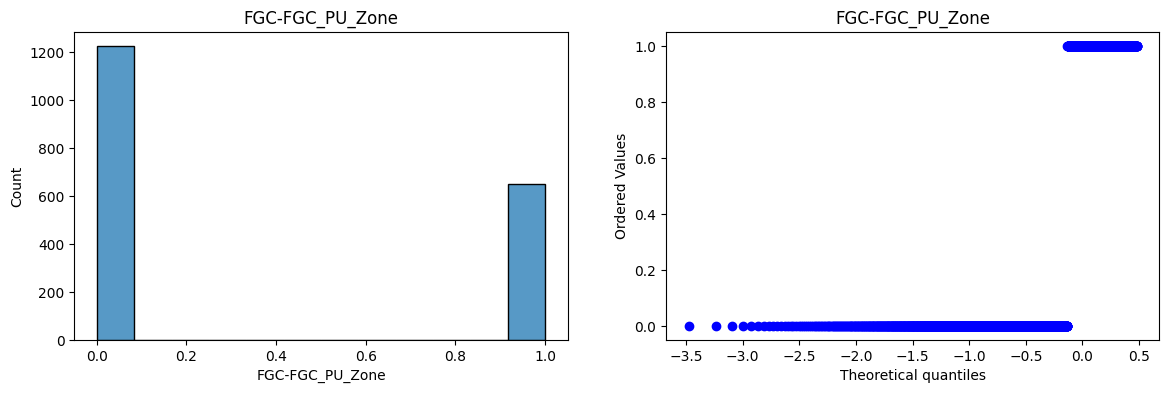

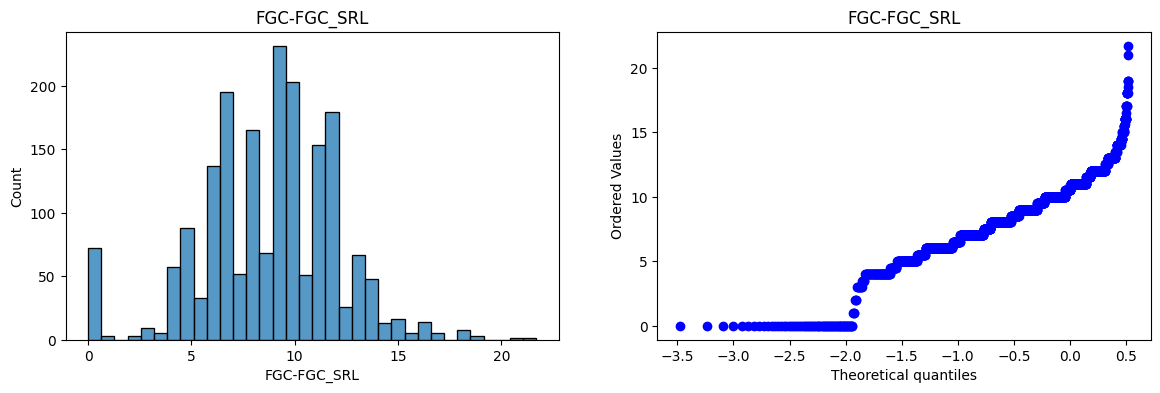

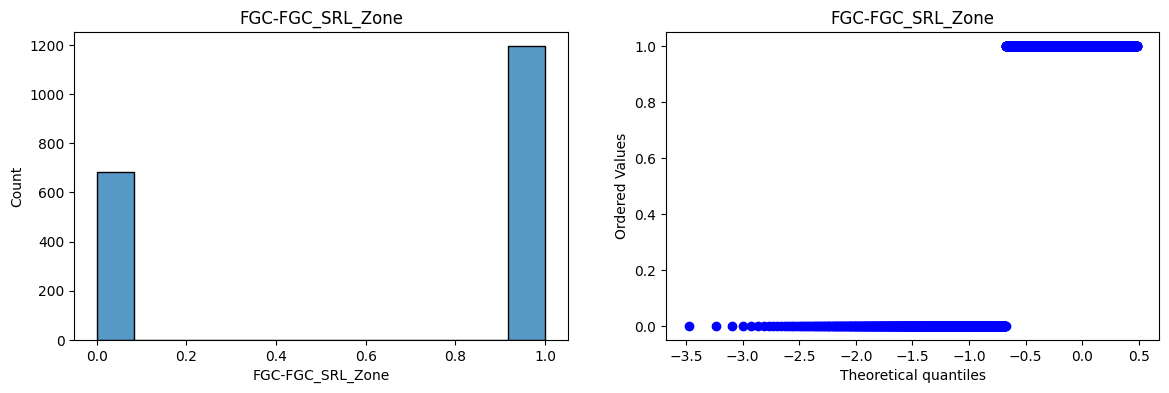

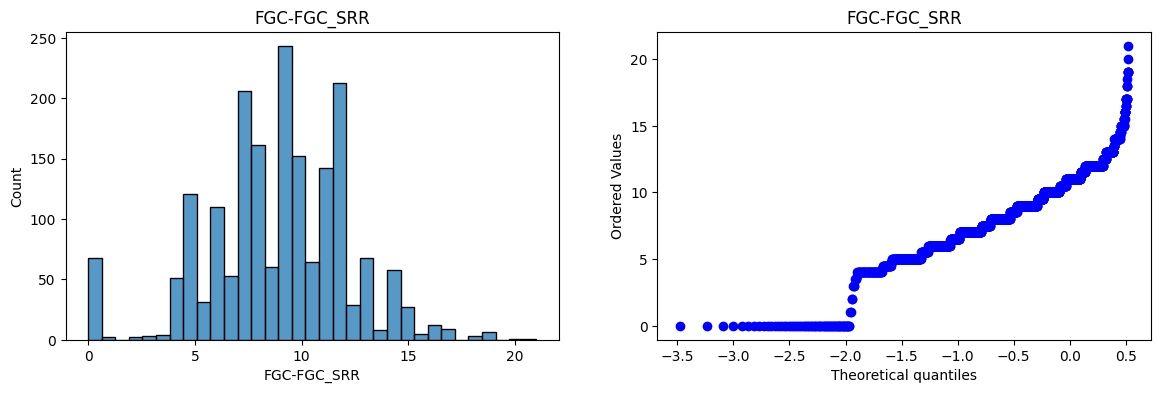

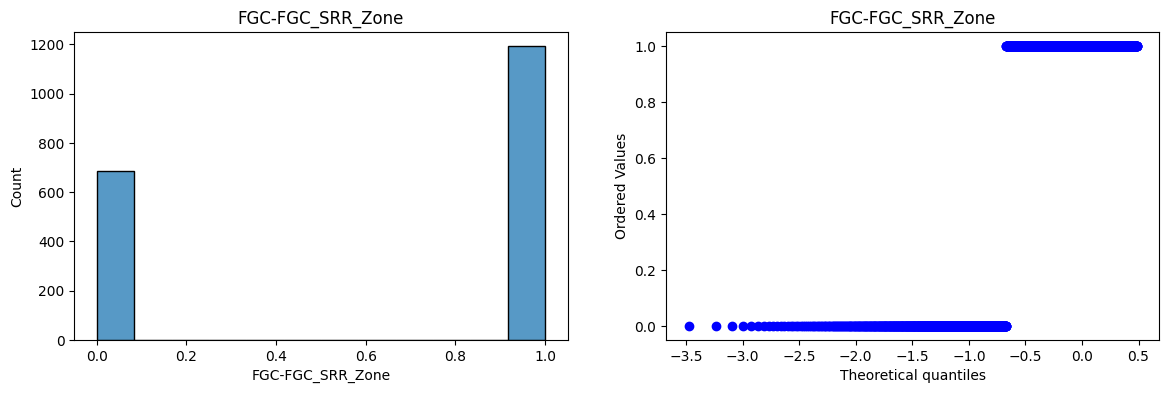

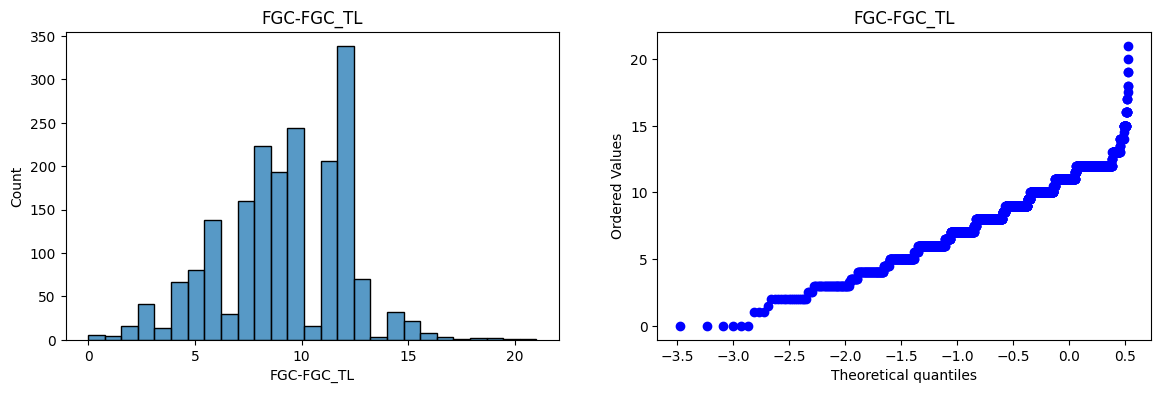

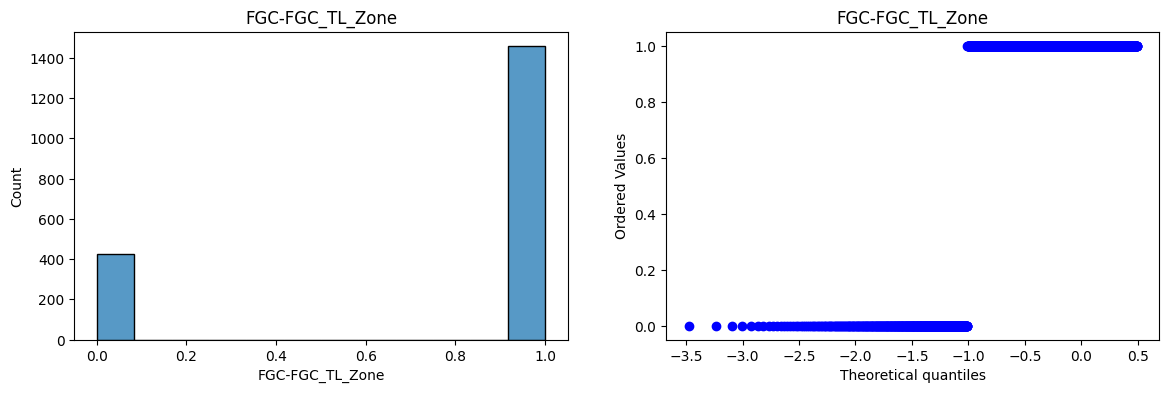

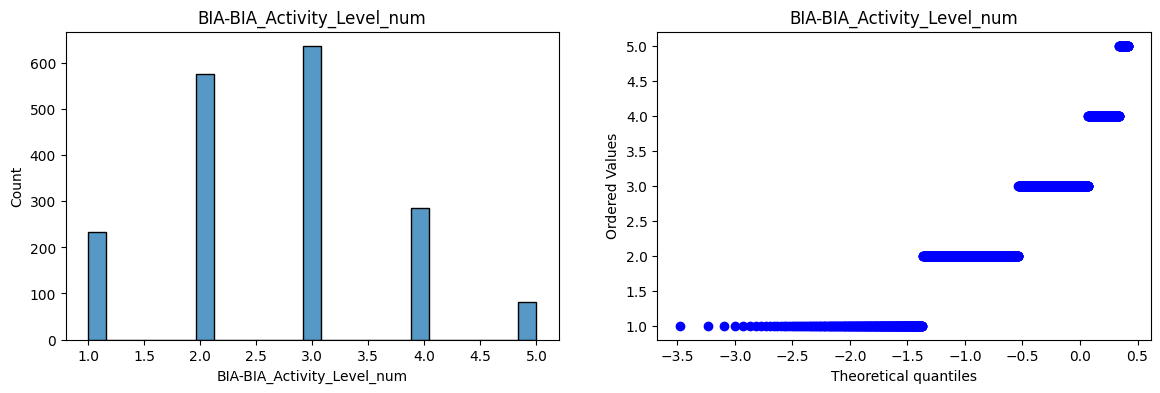

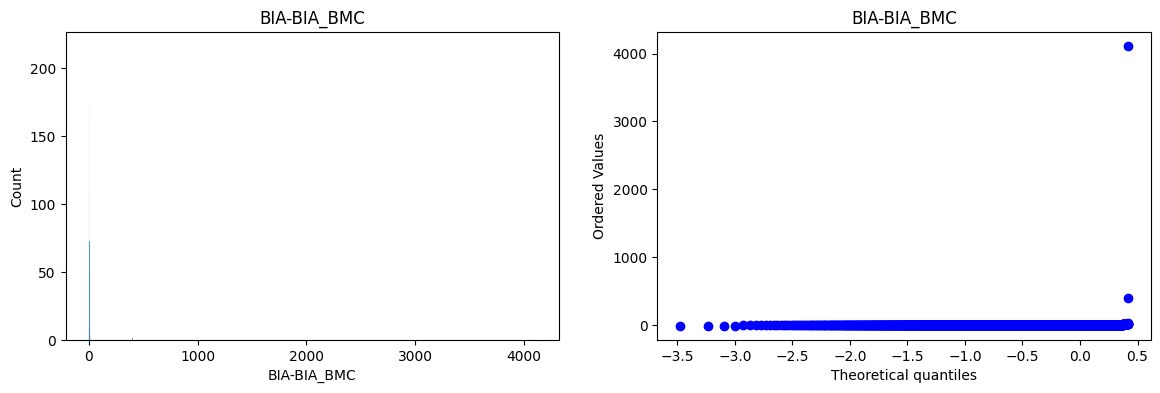

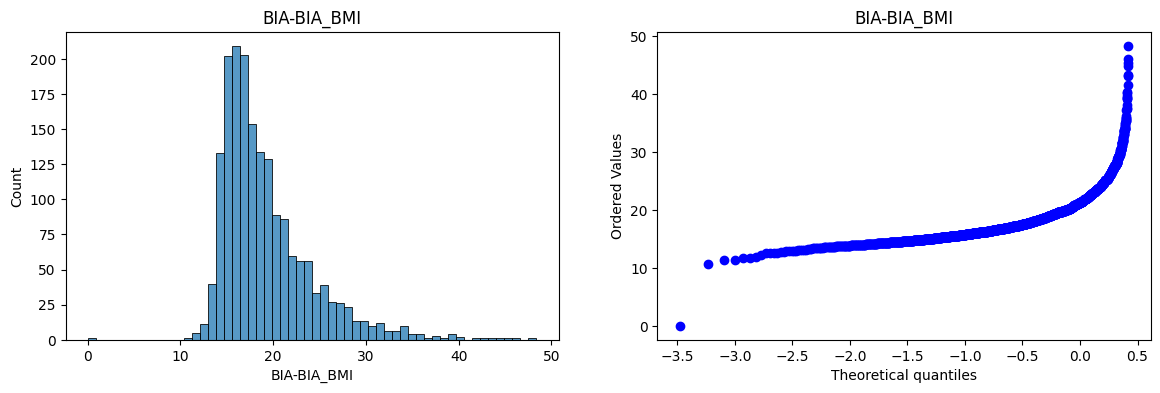

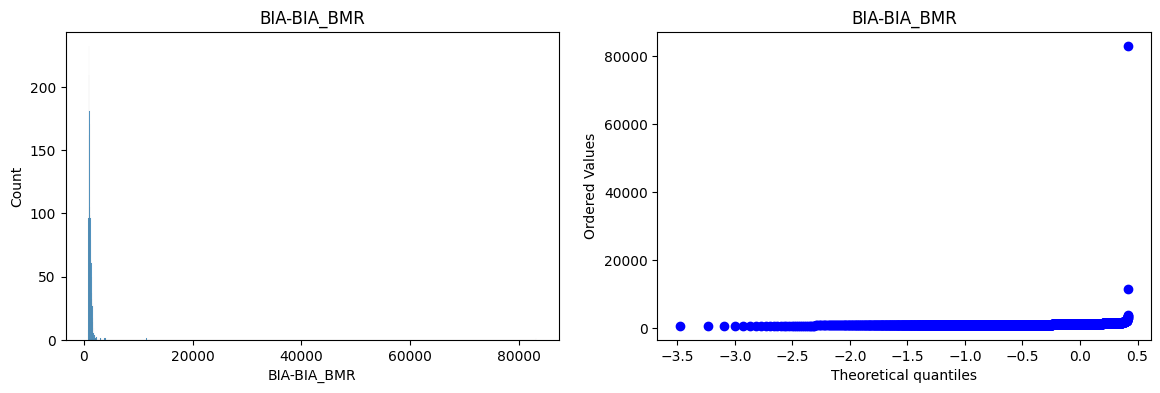

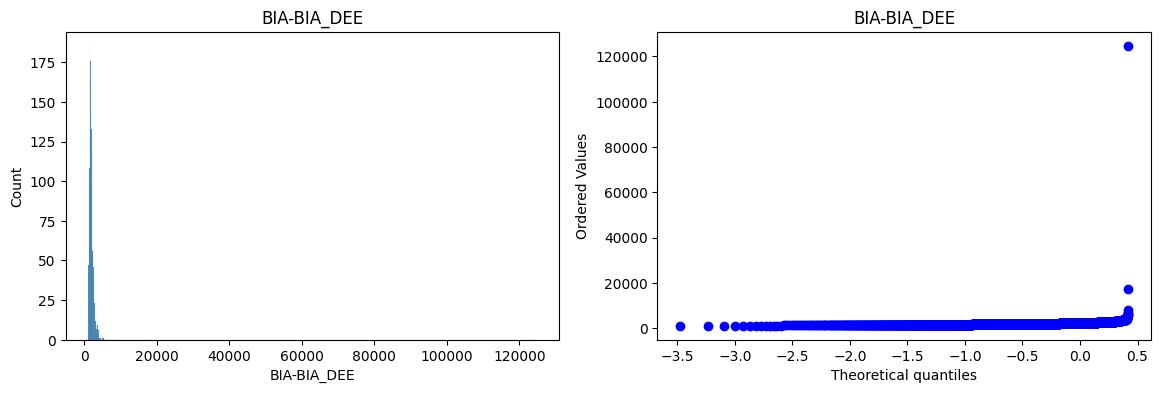

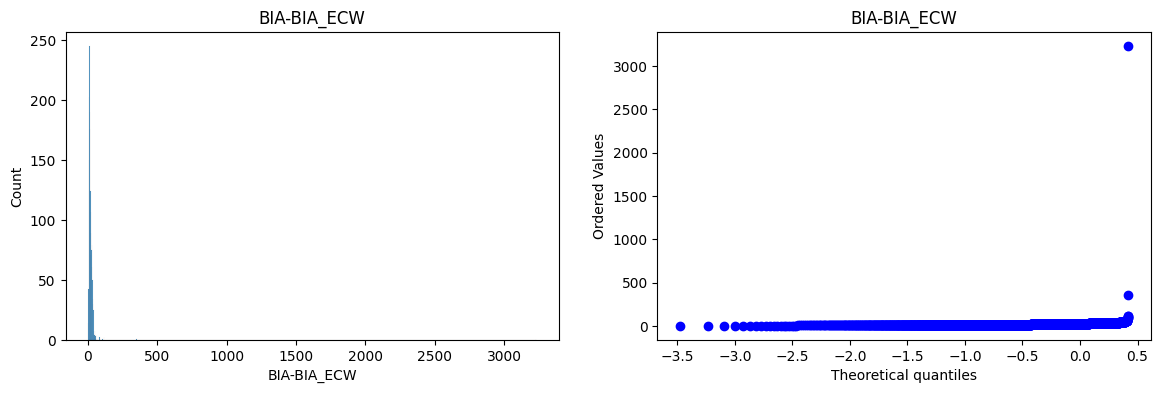

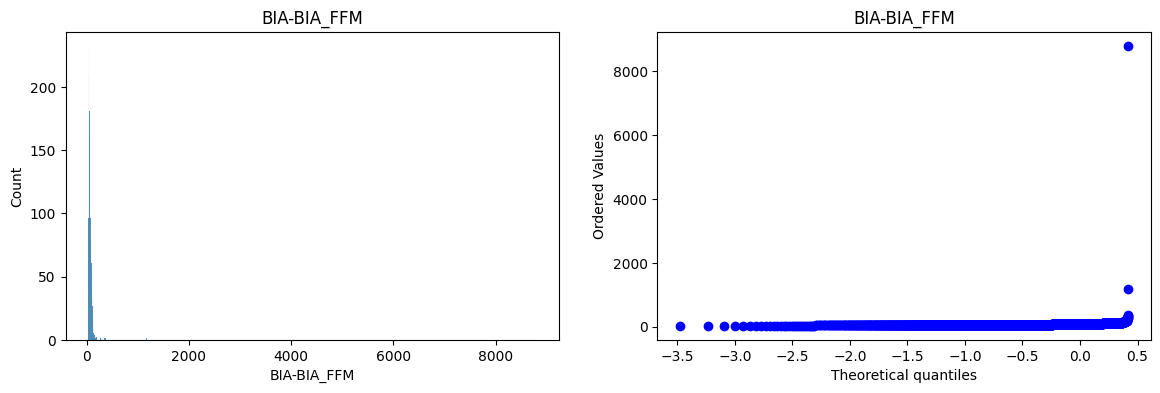

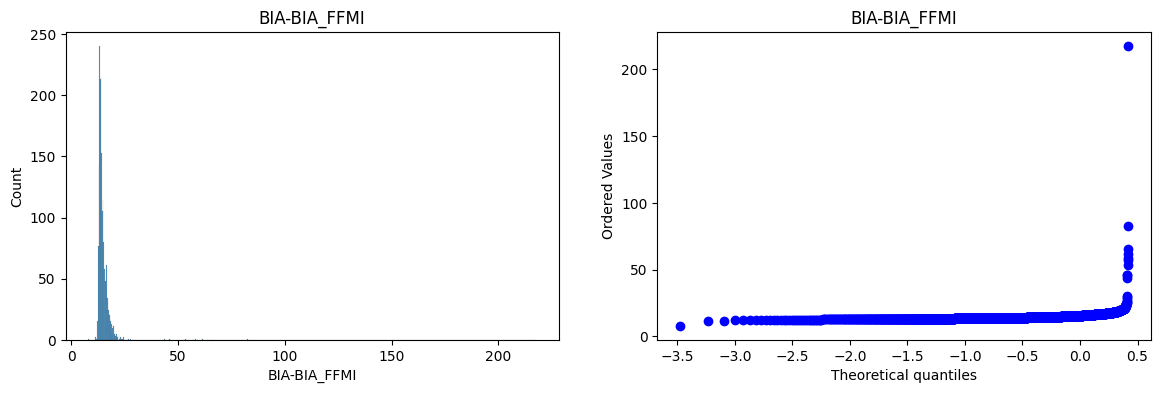

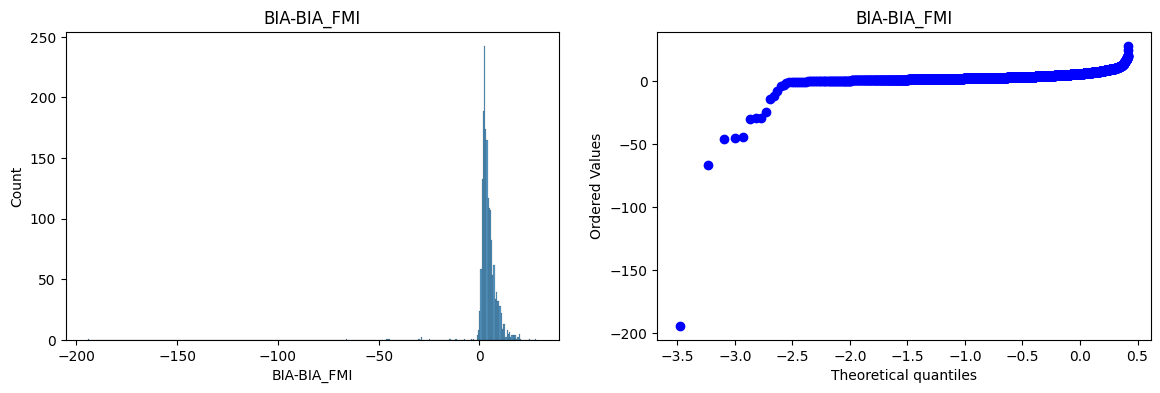

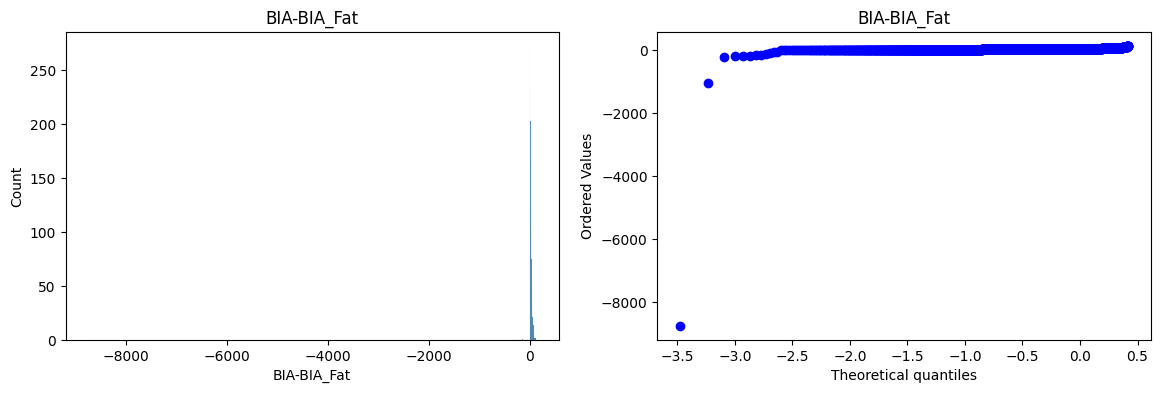

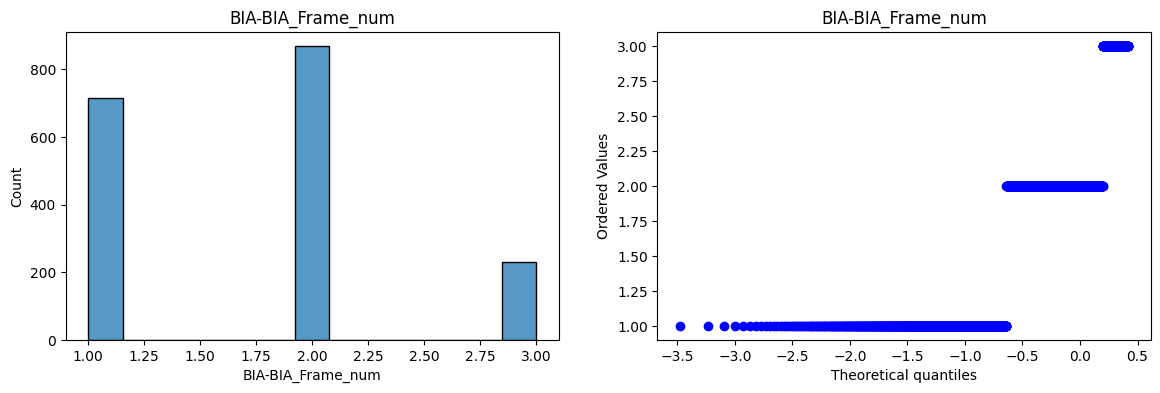

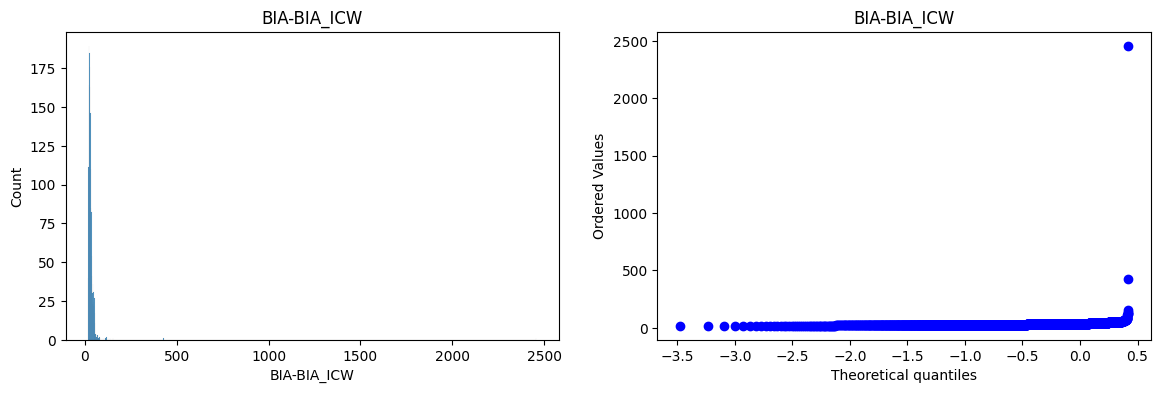

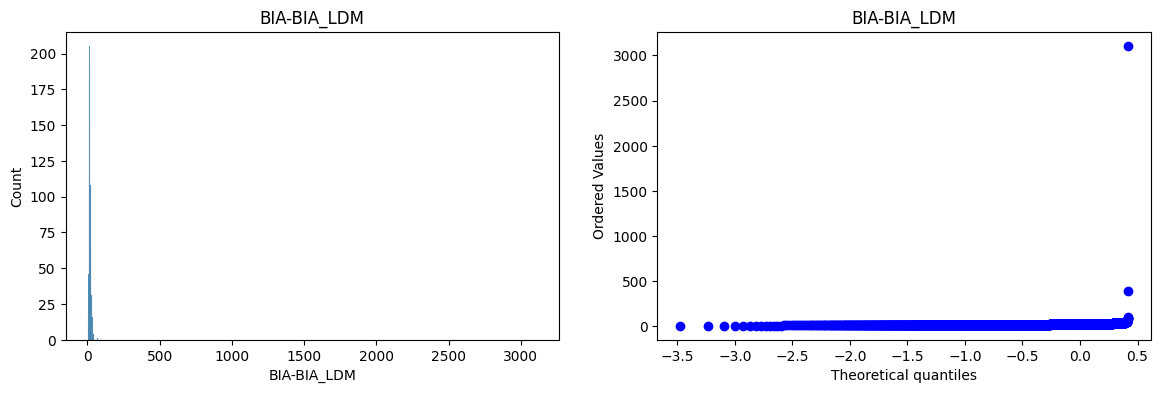

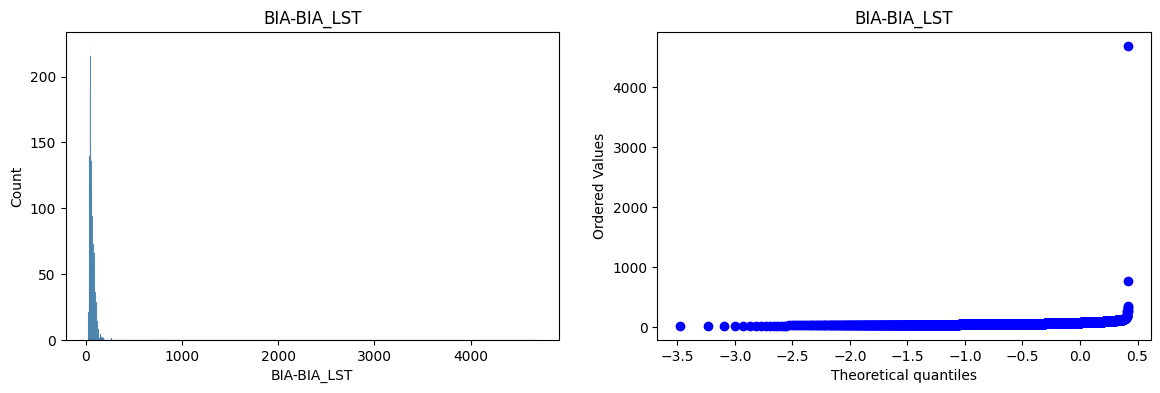

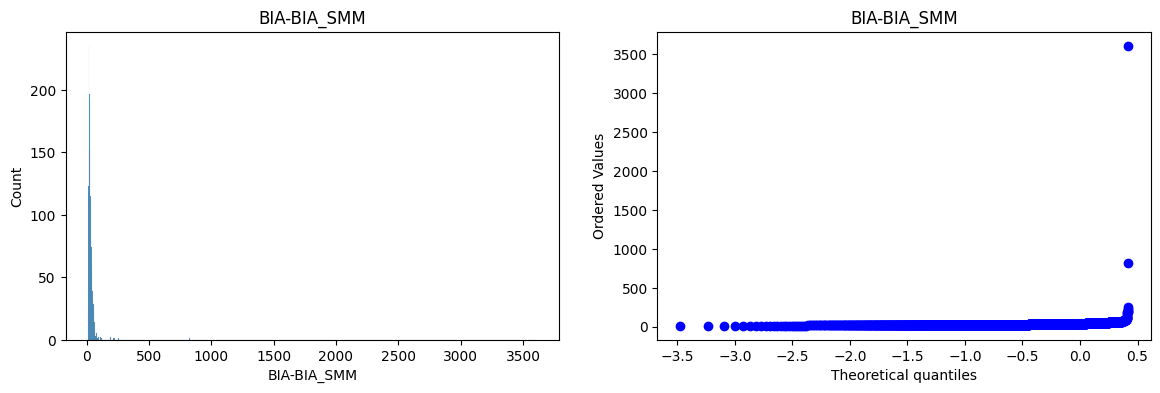

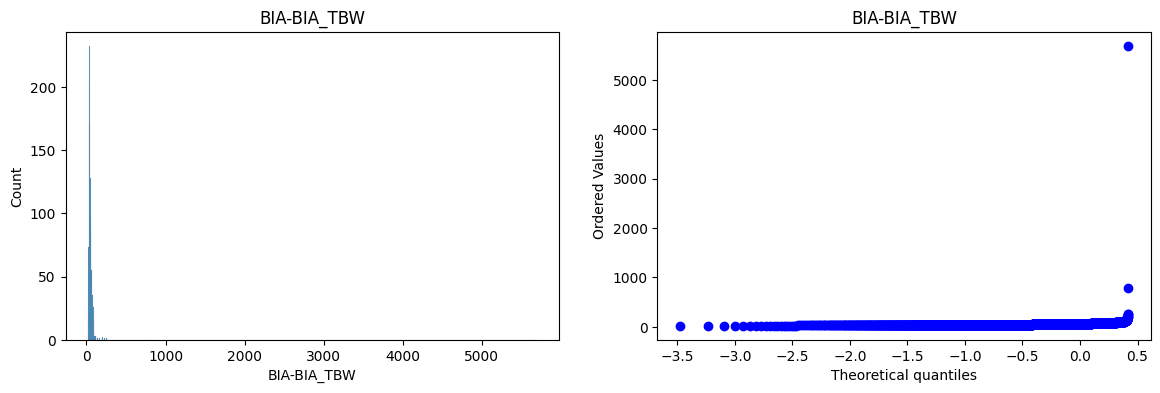

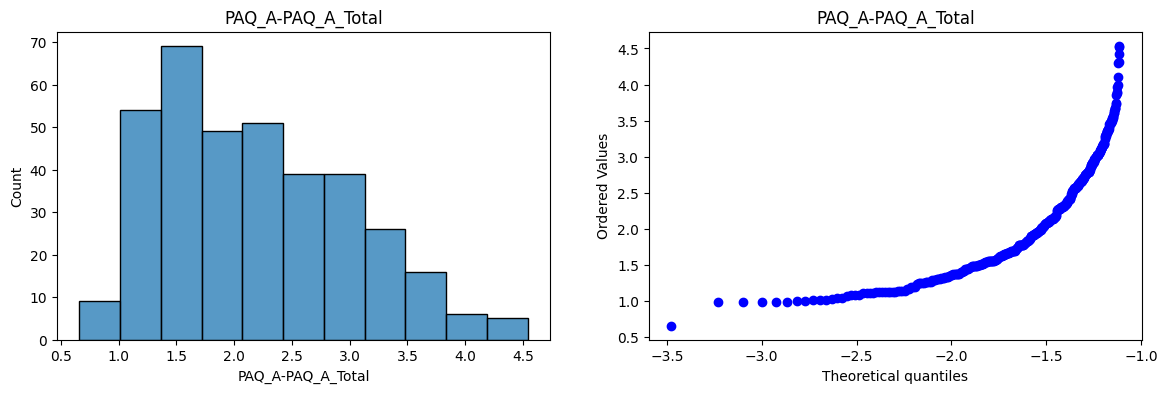

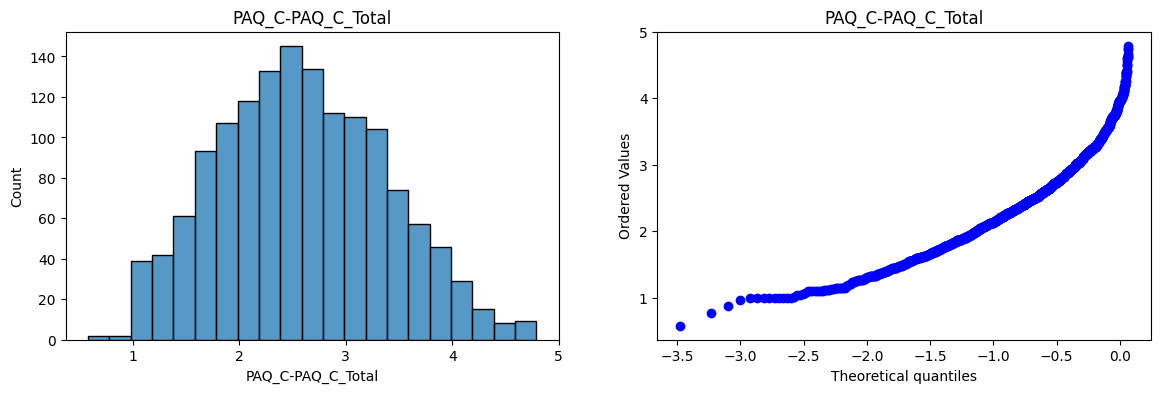

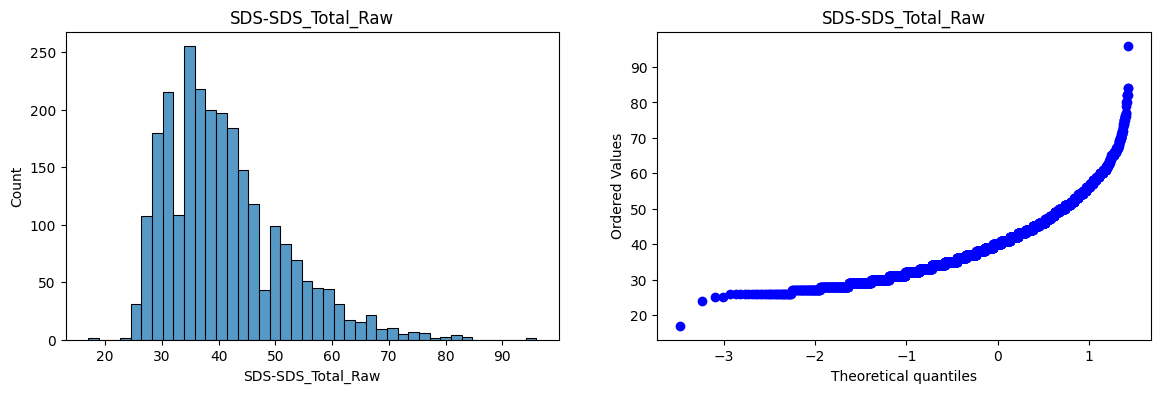

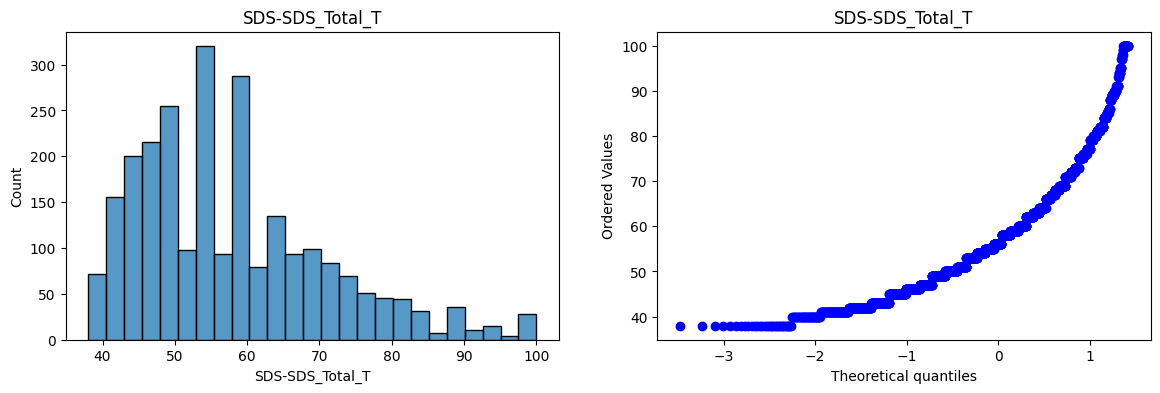

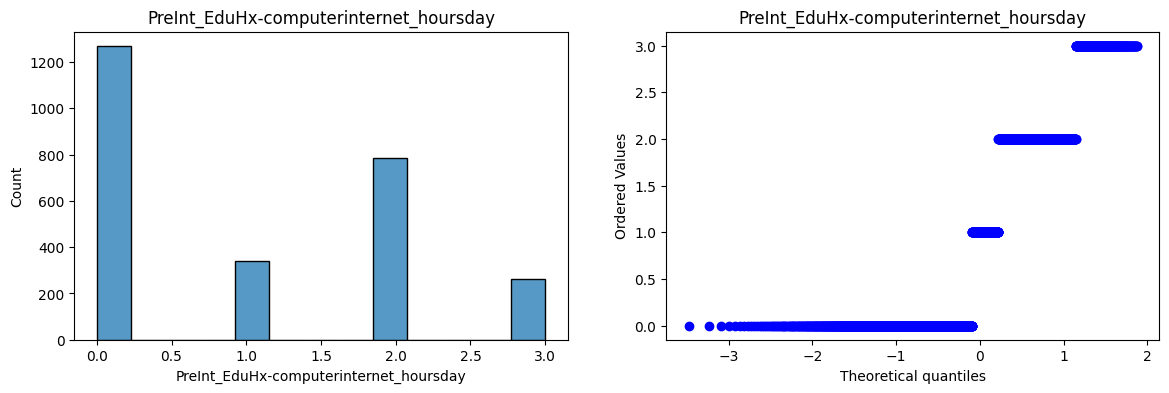

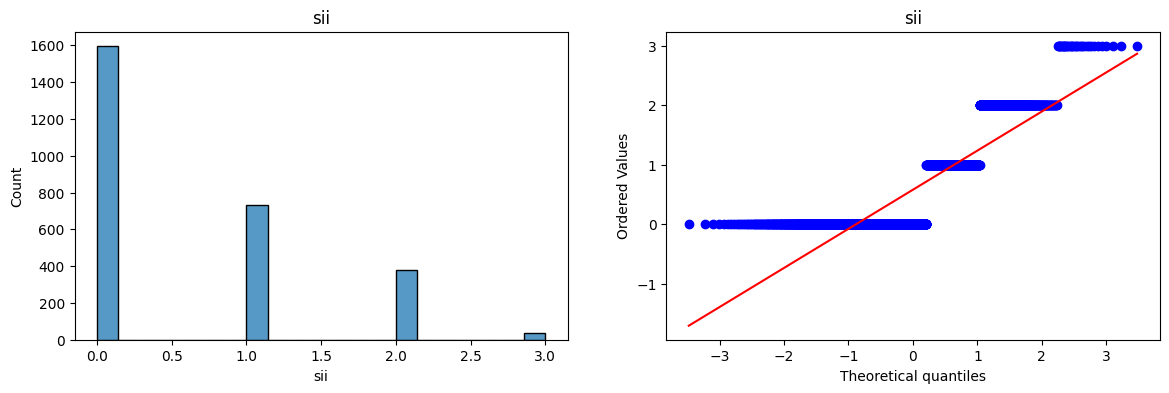

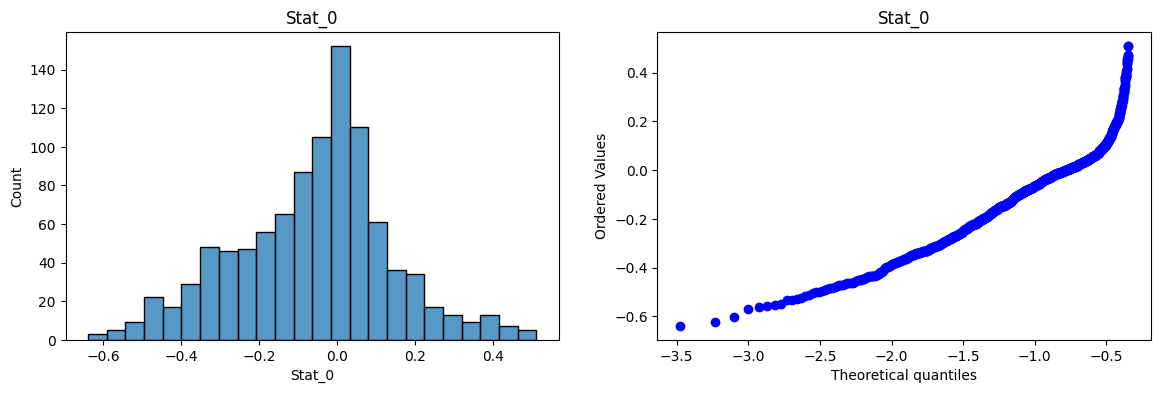

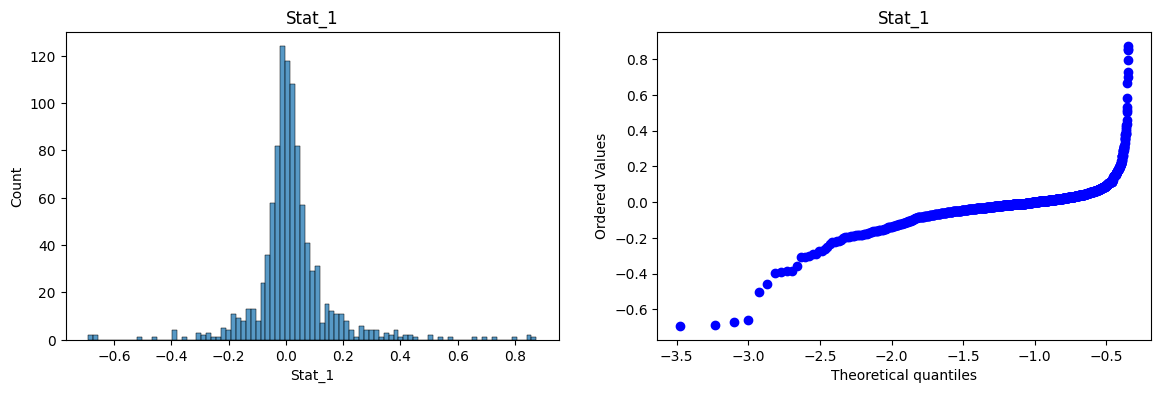

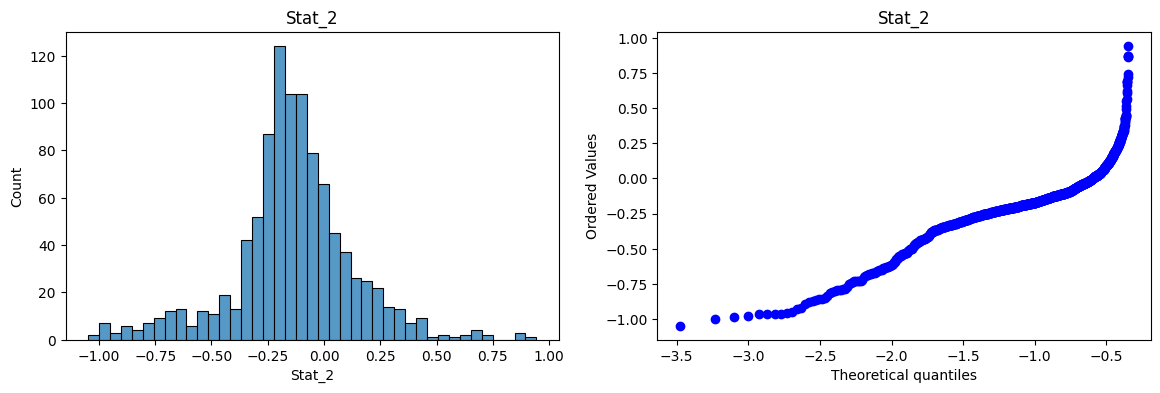

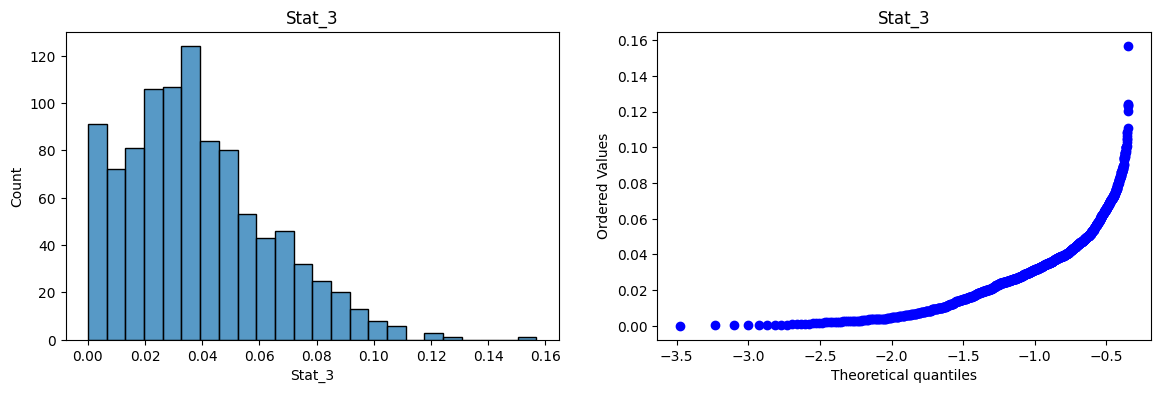

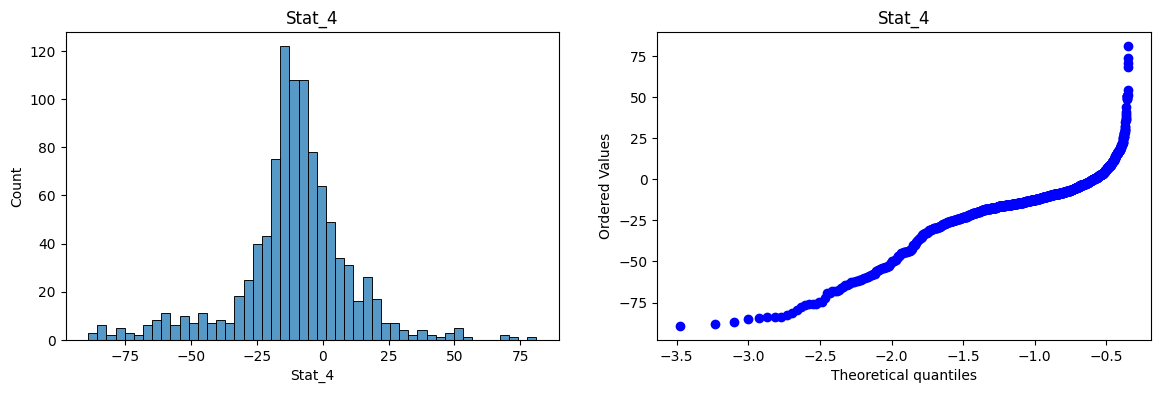

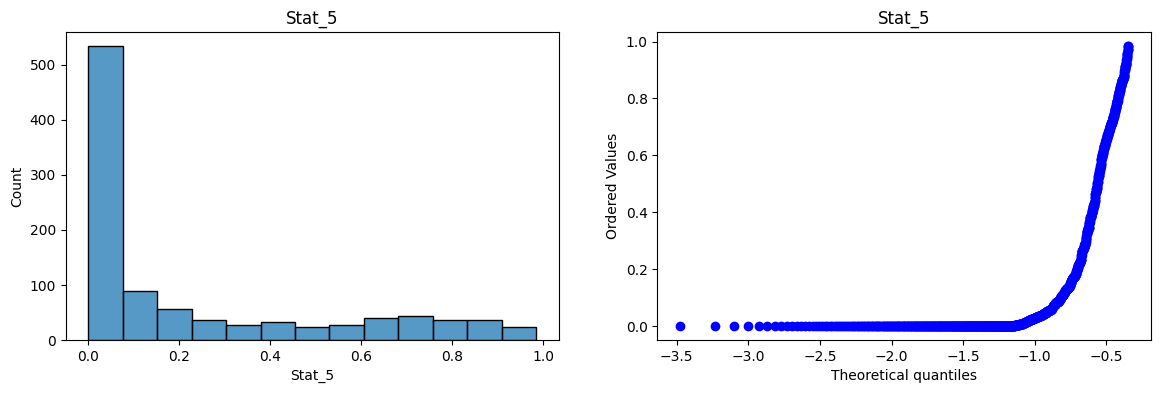

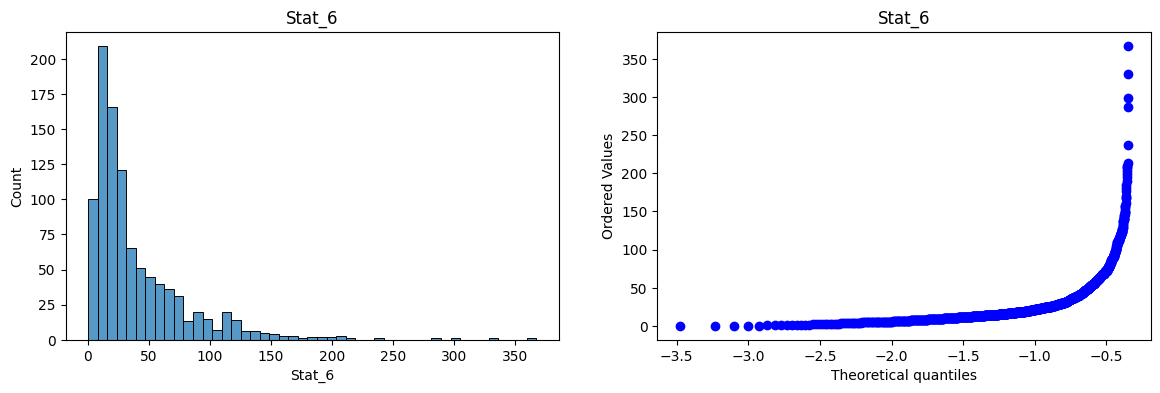

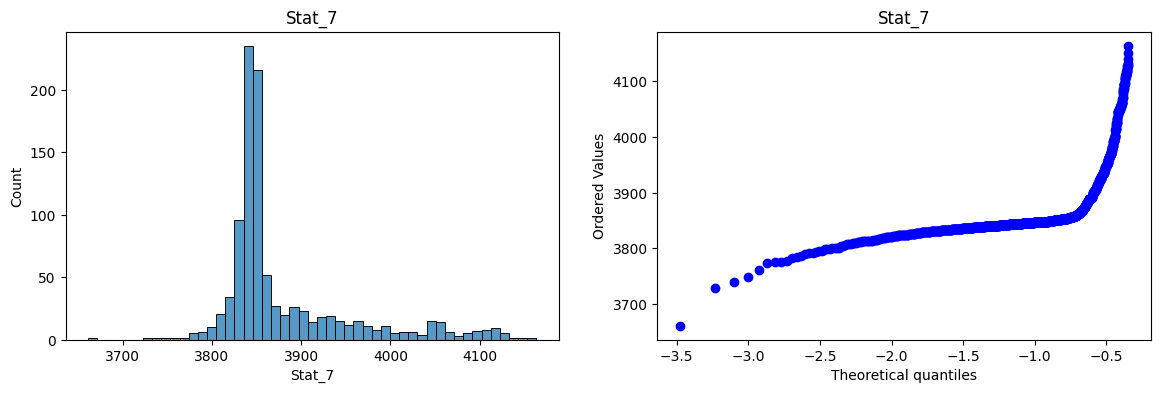

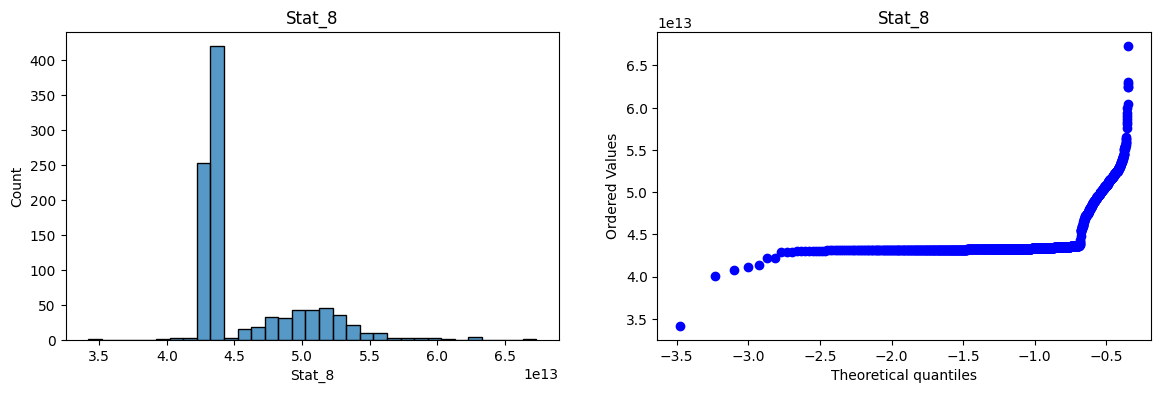

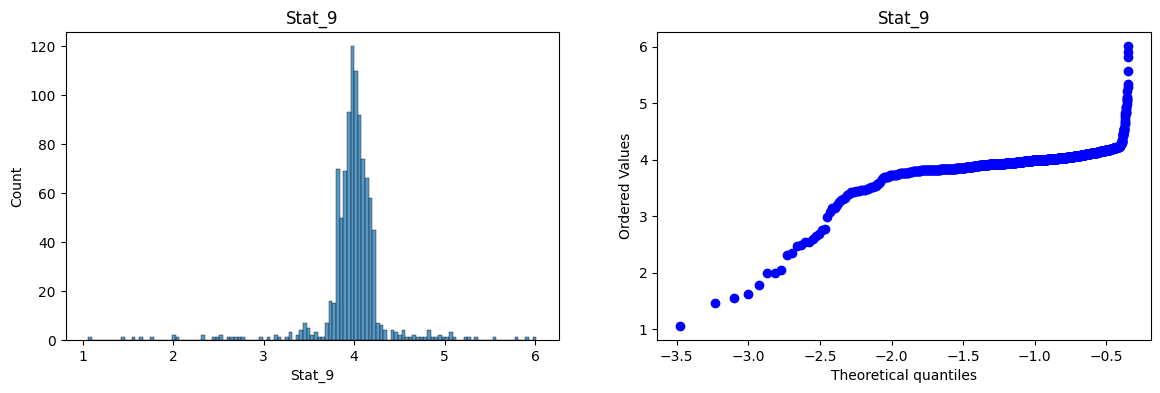

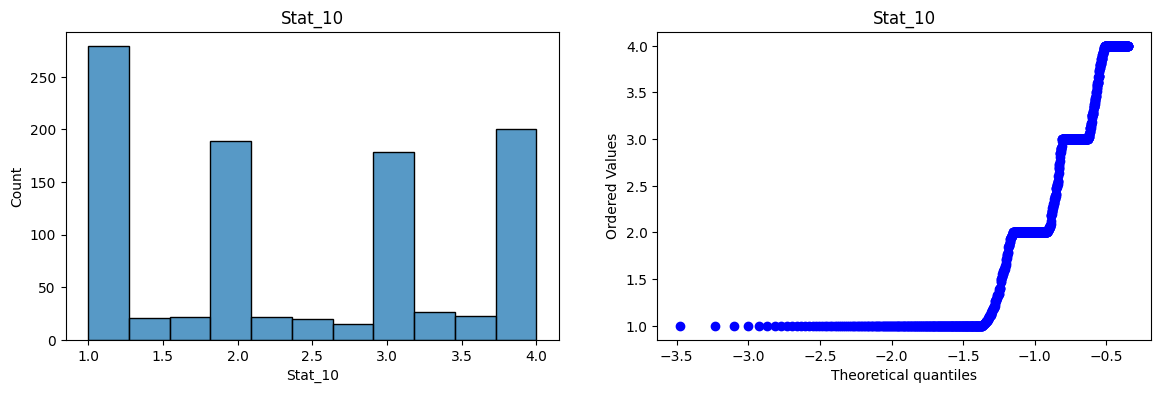

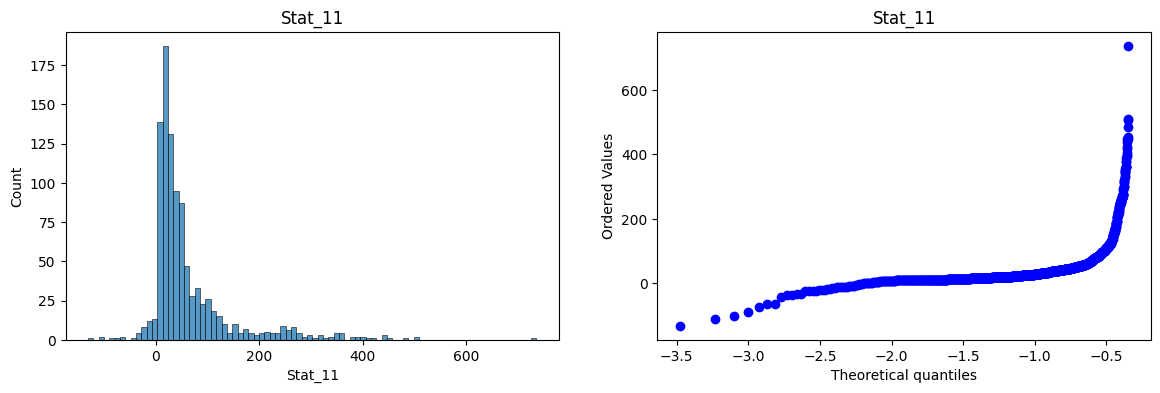

In [16]:
import scipy.stats as stats
for column in train.columns : 
    plt.figure(figsize = (14,4))
    plt.subplot(121)
    sns.histplot(train[column])
    plt.title(column)
    
    plt.subplot(122)
    stats.probplot(train[column],dist = 'norm', plot = plt)
    plt.title(column)
    plt.show()

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">⚖️Quadratic Weighted Kappa</span>

In [17]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = model_class
        
        for name, model in model_class.items():
            print("Name")
            print(name)
            model.fit(X_train, y_train)

        y_train_pred = blend_predict(X_train)
        y_val_pred = blend_predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = blend_predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    print(KappaOPtimizer.x)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,model

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑Explaining Quadratic Weighted Kappa</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Function <strong>quadratic_weighted_kappa</strong></h2>
  <p style="color:black;">This function calculates the quadratic weighted kappa score between two sets of labels (<strong>y_true</strong> and <strong>y_pred</strong>). It utilizes the <strong>cohen_kappa_score</strong> function from scikit-learn with the <strong>weights='quadratic'</strong> argument.</p>
<strong>Code:</strong>
<span>
  def quadratic_weighted_kappa(y_true, y_pred):<br/>
      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;return cohen_kappa_score(y_true, y_pred, weights='quadratic')</span>
    
<h2 style="color:black;">Function <strong>TrainML</strong></h2>
<p style="color:black;">This function is responsible for training a machine learning model and evaluating its performance. It takes the model class (<strong>model_class</strong>) and testing data (<strong>test_data</strong>) as input.</p>

<ul>
<li>It separates the target variable (<strong>sii</strong>) from the features in the training data (<strong>X</strong> and <strong>y</strong>).</li>
<li>It uses <strong>StratifiedKFold</strong> to perform stratified K-Fold cross-validation, ensuring balanced class distribution in each fold.</li>
<li>It initializes arrays to store training and validation kappa scores (<strong>train_S</strong>, <strong>test_S</strong>), predicted probabilities (<strong>oof_non_rounded</strong>), rounded predictions (<strong>oof_rounded</strong>), and test set predictions (<strong>test_preds</strong>).</li>
<li>It iterates through each fold using a progress bar (<strong>tqdm</strong>).</li>
<ul>
<li>Within each fold, it splits the training data into training and validation sets (<strong>X_train</strong>, <strong>X_val</strong>, <strong>y_train</strong>, <strong>y_val</strong>).</li>
<li>It iterates through each model within the provided model class (<strong>model_class</strong>).</li>
<ul>
<li>It prints the model name for debugging purposes.</li>
<li>It fits the model on the training data (<strong>model.fit(X_train, y_train)</strong>).</li>
</ul>
<li>It predicts probabilities for both the training and validation sets using a blending function (<strong>blend_predict</strong>).</li>
<li>It stores the predicted probabilities for the validation set (<strong>oof_non_rounded</strong>) and rounds them to integers for evaluation (<strong>oof_rounded</strong>).</li>
<li>It calculates and stores the quadratic weighted kappa scores for the training and validation sets (<strong>train_kappa</strong>, <strong>val_kappa</strong>).</li>
<li>It appends these kappa scores to their respective lists (<strong>train_S</strong>, <strong>test_S</strong>).</li>
<li>It predicts probabilities for the test data using the blending function and stores them (<strong>test_preds[:, fold] = blend_predict(test_data)</strong>).</li>
<li>It prints the fold number, training kappa score, and validation kappa score.</li>
</ul>
<li>It prints the mean training and validation kappa scores.</li>
<li>It defines an optimization problem using <strong>minimize</strong> to find the optimal thresholds for rounding the predicted probabilities. This optimization minimizes the negative quadratic weighted kappa (<strong>evaluate_predictions</strong>) on the validation set (<strong>y</strong>, <strong>oof_non_rounded</strong>). The Nelder-Mead method is used for optimization.</li>
<li>It asserts that the optimization converged successfully.</li>
<li>It applies the optimized thresholds to the validation set probabilities (<strong>oof_tuned</strong>) and calculates the final kappa score (<strong>tKappa</strong>).</li>
<li>It prints the optimized kappa score.</li>
<li>It calculates the mean of the predicted probabilities across all folds for the test set (<strong>tpm</strong>).</li>
<li>It retrieves the optimized thresholds from the optimization result (<strong>KappaOPtimizer.x</strong>).</li>
<li>It applies the optimized thresholds to the mean test set probabilities (<strong>tpTuned</strong>).</li>
<li>Finally, it creates a submission DataFrame with the IDs from the sample data and the rounded predictions (<strong>tpTuned</strong>) and returns this DataFrame along with the trained model.</li>
</ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🖥️Pipelines and Models</span>

In [18]:
# Create pipelines for  Catboost Regression, LightGBM Regression, and XGBoost Regression
SEED = 5

#Using LGBMRegressor
Params_lgb = {
    'learning_rate': 0.03884249148676395, 
    'max_depth': 12, 
    'num_leaves': 413, 
    'min_data_in_leaf': 14,
    'feature_fraction': 0.7987976913702801, 
    'bagging_fraction': 0.7602261703576205, 
    'bagging_freq': 2, 
    'lambda_l1': 4.735462555910575, 
    'lambda_l2': 4.735028557007343e-06
} 

Light = lgb.LGBMRegressor(**Params_lgb,random_state=SEED, verbose=-1,n_estimators=200)


# Using XGBRegressor
Params_xgb = {
    'learning_rate': 0.03884249148676395,
    'max_depth': 12,
    'max_leaves': 413,
    'min_child_weight': 14,
    'colsample_bytree': 0.7987976913702801,
    'subsample': 0.7602261703576205,
    'reg_alpha': 4.735462555910575,
    'reg_lambda': 4.735028557007343e-06
}

XGBoost = xgb.XGBRegressor(**Params_xgb, random_state=SEED, verbosity=0, n_estimators=200)


# Using CatBoostRegressor
# Params_cat = {
#     'learning_rate': 0.03884249148676395,
#     'max_depth': 12,
#     'min_child_samples': 14,  # Equivalent to min_data_in_leaf
#     'rsm': 0.7987976913702801,  # Equivalent to feature_fraction
#     'subsample': 0.7602261703576205,  # Equivalent to bagging_fraction
#     'l2_leaf_reg': 4.735462555910575,  # Equivalent to lambda_l2/lambda_l1
#     'random_seed': SEED,  # Use same seed for reproducibility
#     'n_estimators': 200,  # Number of trees
#     'verbose': 0  # Suppresses output
# }


# CatBoost = CatBoostRegressor(**Params_cat)

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">📕Create Dictionaries and Predict</span>

In [19]:
# Create a dictionary to store the models
models = {'XGBoostRegressor': XGBoost, 
          'LightGBMRegressor': Light}

# Initialize dictionaries for predictions and scores
predictions = {}
scores = {}

def blend_predict(X):
    return ((0.6 * Light.predict(X)) +
            (0.4 * XGBoost.predict(X)))

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🚅Train Model</span>

In [20]:
Submission, model = TrainML(models, test)

Training Folds: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

Mean Train QWK --> 0.8192
Mean Validation QWK ---> 0.3895


----> || Optimized QWK SCORE ::  0.454
[0.60288628 1.03158758 2.74094168]


# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">📁Submission</span>

In [21]:
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
0    12
1     8
Name: count, dtype: int64


In [22]:
Submission.head(20)

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0


# :) More coming Soon